# Setup

In [1]:
%matplotlib widget
%matplotlib inline

import ipywidgets as widgets
interact = widgets.interact
import numpy as np
import matplotlib.pyplot as plt

import pathlib
import torch as t
from tqdm.notebook import tqdm
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
rootdir=pathlib.Path("./saved_models/")
rootdir.mkdir(exist_ok=True)

from IPython.display import display, clear_output

from model_fns import UncorrelatedTMS, CorrelatedTMS, AntiCorrelatedTMS, ComposedFeatureTMS, ToyModelConfig
from autoencoder_fns import AutoEncoder, AutoEncoderConfig
from plot_fns import w_cossim, w_enc

saes = []

# Plotting

In [35]:
def plot_sae_imshows(sae, model, sae_log):
    fig = plt.figure(figsize=(5, 7.5))
    
    cax1 = fig.add_axes([0.05, 0.97, 0.4, 0.03])
    cax2 = fig.add_axes([0.55, 0.97, 0.4, 0.03])
    ax1_1 = fig.add_axes([0.025, 0.95-0.19*1, 0.45, 0.16])
    ax1_2 = fig.add_axes([0.025, 0.95-0.19*2, 0.45, 0.16])
    ax1_3 = fig.add_axes([0.025, 0.95-0.19*3, 0.45, 0.16])
    ax1_4 = fig.add_axes([0.025, 0.95-0.19*4, 0.45, 0.16])
    ax1_5 = fig.add_axes([0.025, 0.95-0.19*5, 0.45, 0.16])
    
    ax2_1 = fig.add_axes([0.525, 0.95-0.19*1, 0.45, 0.16])
    ax2_2 = fig.add_axes([0.525, 0.95-0.19*2, 0.45, 0.16])
    ax2_3 = fig.add_axes([0.525, 0.95-0.19*3, 0.45, 0.16])
    ax2_4 = fig.add_axes([0.525, 0.95-0.19*4, 0.45, 0.16])
    ax2_5 = fig.add_axes([0.525, 0.95-0.19*5, 0.45, 0.16])
    
    axs_left = [ax1_1, ax1_2, ax1_3, ax1_4, ax1_5]
    axs_right = [ax2_1, ax2_2, ax2_3, ax2_4, ax2_5]
    # print(sae_log.keys())
    # print(sae_log['monosemanticity'])
    
    for i, axs in enumerate(zip(axs_left, axs_right)):
        actvecs, argsacts = w_enc(model, sae, instance=i)
        cossim, args = w_cossim(model.W, sae.W_dec[i], sort=argsacts)
    
        axL, axR = axs
    
        activations = axL.imshow(actvecs.squeeze(), vmin=0, vmax=1)
        coss = axR.imshow(cossim.squeeze(), vmin=-1, vmax=1, cmap='RdBu_r')
    
        if i == 0:
            plt.colorbar(activations, cax=cax1, orientation='horizontal')
            plt.colorbar(coss, cax=cax2, orientation='horizontal')
            cax1.text(0.5, 1.05, r'$\mathrm{ReLU}(I\,W\,W_{\mathrm{enc}} + b_{\mathrm{enc}})$', ha='center', va='bottom', transform=cax1.transAxes)
            cax2.text(0.5, 1.05, r'$\mathrm{Cos-sim}_{ij}(W_{ik}, W_{\rm{dec}, jk})$', ha='center', va='bottom', transform=cax2.transAxes)
    
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)
        axL.text(0.98, 0.97, f'{sae_log["monosemanticity"][-1][i]:.2f}', ha='right', va='top', bbox=props, transform=axL.transAxes)

# Small composed models (8 features, 2 sets)

## Uncorrelated feature amplitudes

### Model and simple SAEs

In [3]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
feats_per_set = 4
cfg = ToyModelConfig(hidden_size=feats_per_set,
                     feat_sets=(feats_per_set,feats_per_set),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=(1,1),
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, # seems important for getting composed pairs.
                     )

model = ComposedFeatureTMS(cfg).to(device)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)

probability table: 
tensor([[0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625]])
attempting to load


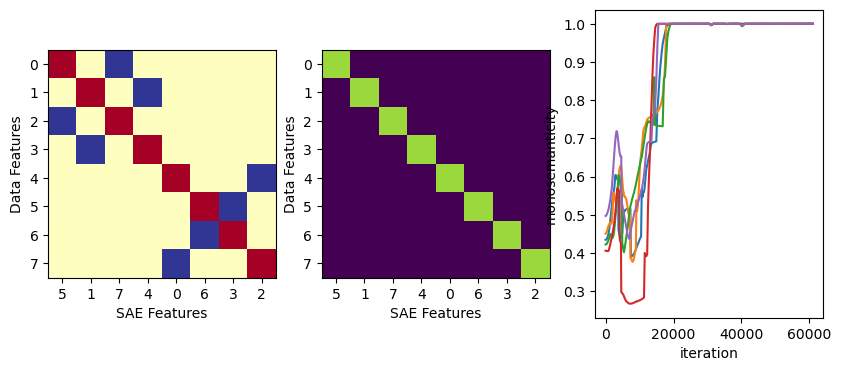

In [4]:
lr=3e-4
l1_coeff = 0.3
d_sae = feats_per_set*2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

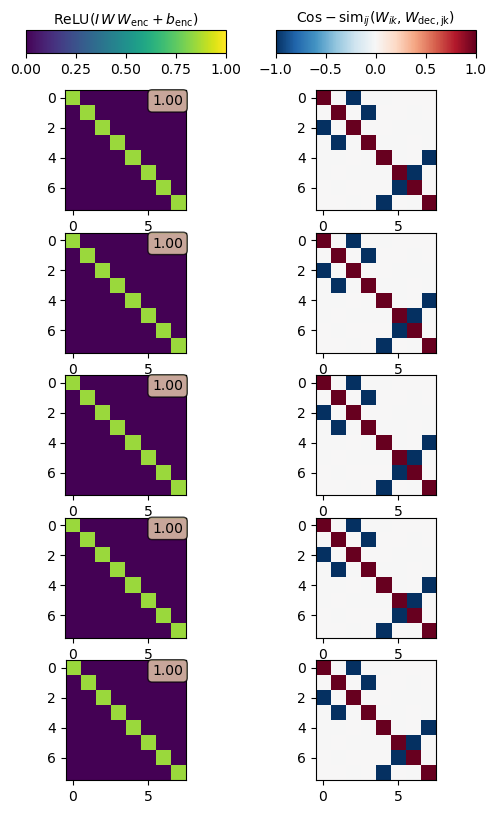

In [5]:

plot_sae_imshows(single_sae, model, sae_log)

### Model and simple SAEs (3 hidden dims)

In [6]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
hidden_size = 3
feats_per_set = 4
cfg = ToyModelConfig(hidden_size=hidden_size,
                     feat_sets=(feats_per_set,feats_per_set),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=(1,1),
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, # seems important for getting composed pairs.
                     )

model = ComposedFeatureTMS(cfg).to(device)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)

probability table: 
tensor([[0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625]])
attempting to load


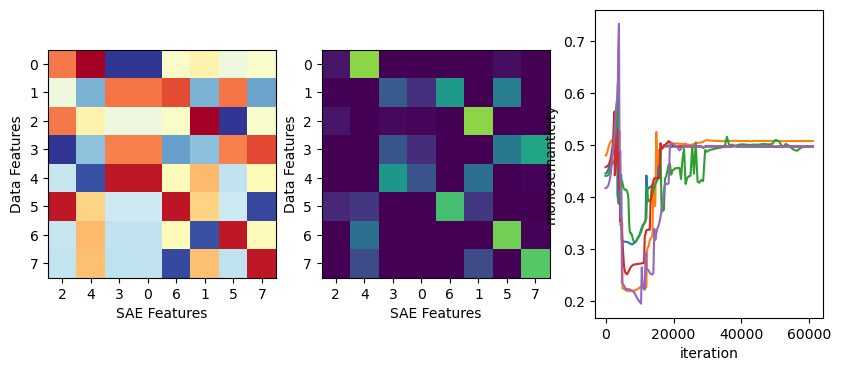

In [7]:
lr=3e-4
l1_coeff = 0.3
d_sae = feats_per_set*2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

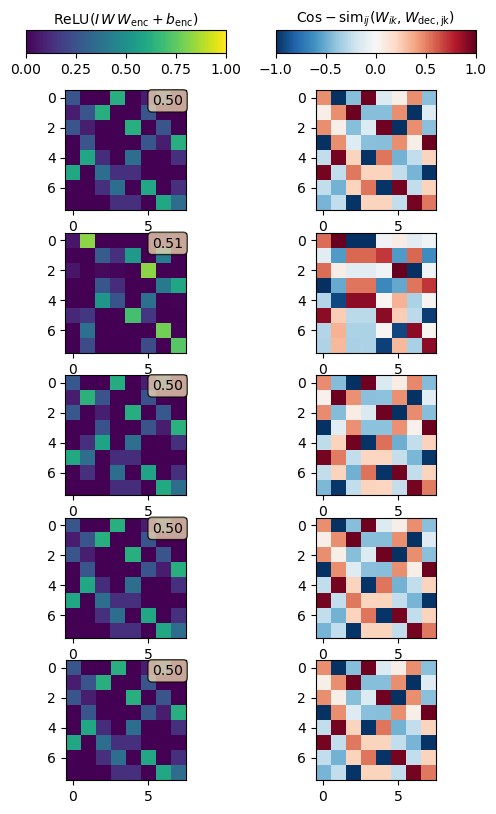

In [9]:

plot_sae_imshows(single_sae, model, sae_log)

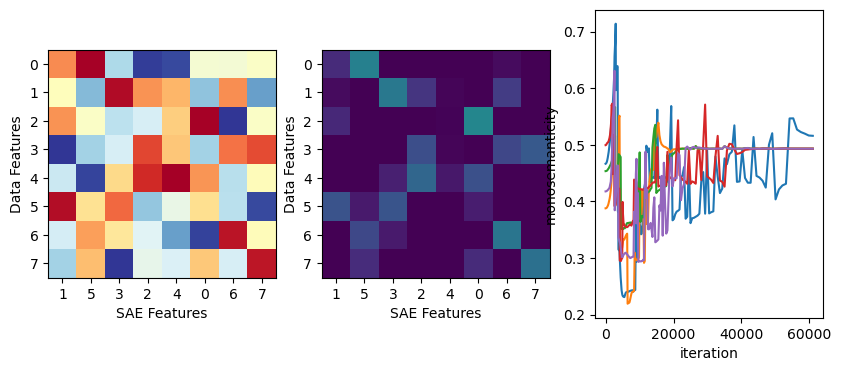

In [14]:
#higher l1.
lr=3e-4
l1_coeff = 1
d_sae = feats_per_set*2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

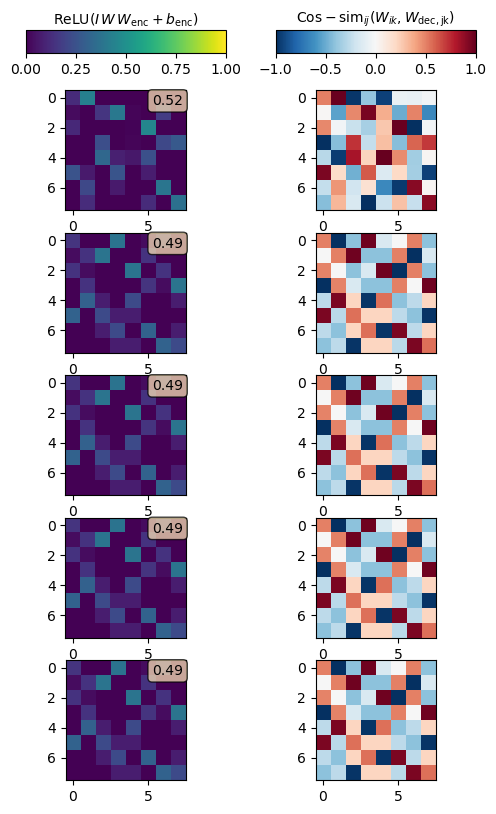

In [15]:

plot_sae_imshows(single_sae, model, sae_log)

# Small composed models (16 features, 2 sets)

## Uncorrelated feature amplitudes

### Model and simple SAEs

In [16]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
feats_per_set = 8
cfg = ToyModelConfig(hidden_size=feats_per_set,
                     feat_sets=(feats_per_set,feats_per_set),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=(1,1),
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, # seems important for getting composed pairs.
                     )

model = ComposedFeatureTMS(cfg).to(device)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)

probability table: 
tensor([[0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156]])
attempting to load


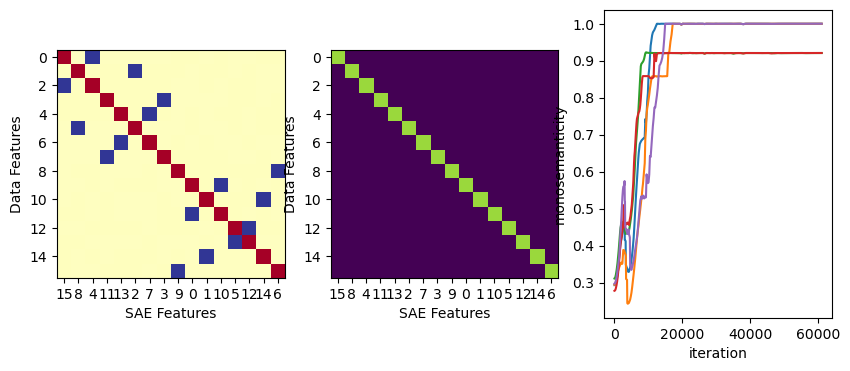

In [17]:
lr=3e-4
l1_coeff = 0.3
d_sae = feats_per_set*2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

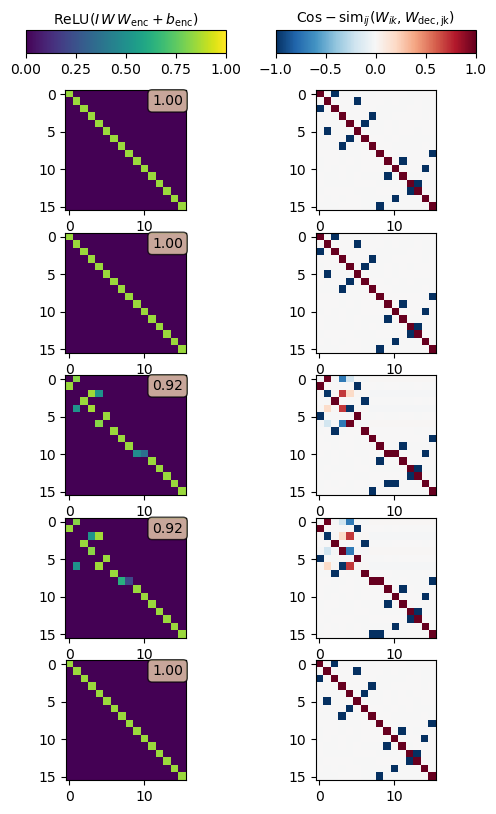

In [18]:

plot_sae_imshows(single_sae, model, sae_log)

### Model and simple SAEs (6 hidden dims)

Note 7 hidden dims is kinda interesting cause one block is antipodal.

In [19]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
hidden_size = 6
feats_per_set = 8
cfg = ToyModelConfig(hidden_size=hidden_size,
                     feat_sets=(feats_per_set,feats_per_set),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=(1,1),
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, # seems important for getting composed pairs.
                     )

model = ComposedFeatureTMS(cfg).to(device)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)

probability table: 
tensor([[0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156]])
attempting to load


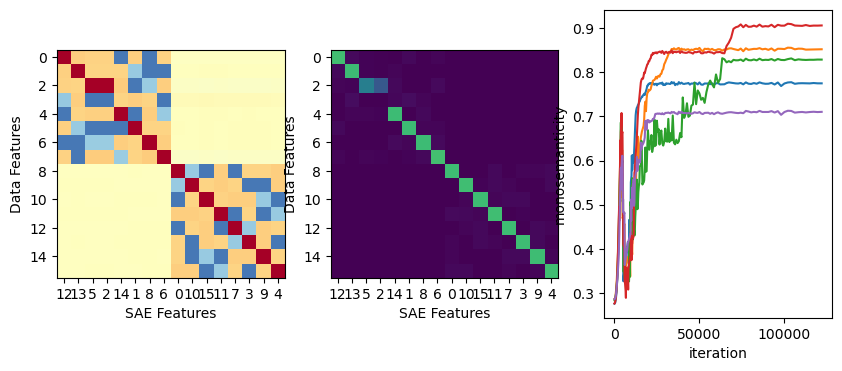

In [25]:
lr=3e-4
l1_coeff = 0.8 #0.3-0.5 does not produce sparsity OR composed pairs!
d_sae = feats_per_set*2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 128_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0.9,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

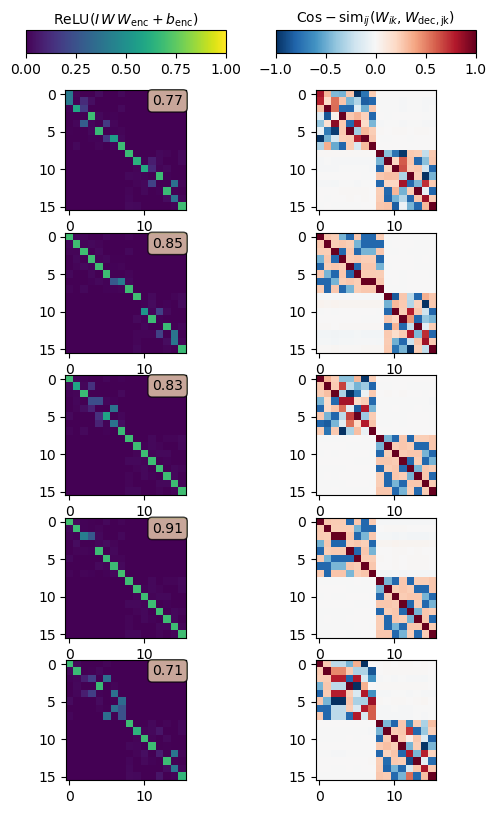

In [26]:

plot_sae_imshows(single_sae, model, sae_log)

## One increasingly correlated feature pair; correlated magnitudes.

### Model and simple SAEs

In [27]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
feats_per_set = 8
hidden_size=6
correlations = [0.2, 0.4, 0.6, 0.8, 0.99]
correlated_models = []

for corr in correlations:
    cfg = ToyModelConfig(hidden_size=hidden_size,
                         feat_sets=(feats_per_set,feats_per_set),
                         batches=10000, 
                         batch_size=1000,
                         correlated_feature_indices=(1,1),
                         correlated_feature_boost=corr,
                         set_magnitude_correlation=0,
                         active_features_per_draw=1, # seems important for getting composed pairs.
                         )
    
    model = ComposedFeatureTMS(cfg).to(device)
    try:
        print('attempting to load')
        model.load(outdir, run_name=cfg.run_name)
    except:
        print('training')
        model.train(outdir=outdir)
    correlated_models.append(model)

probability table: 
tensor([[0.0161, 0.0125, 0.0161, 0.0161, 0.0161, 0.0161, 0.0161, 0.0161],
        [0.0125, 0.0375, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125],
        [0.0161, 0.0125, 0.0161, 0.0161, 0.0161, 0.0161, 0.0161, 0.0161],
        [0.0161, 0.0125, 0.0161, 0.0161, 0.0161, 0.0161, 0.0161, 0.0161],
        [0.0161, 0.0125, 0.0161, 0.0161, 0.0161, 0.0161, 0.0161, 0.0161],
        [0.0161, 0.0125, 0.0161, 0.0161, 0.0161, 0.0161, 0.0161, 0.0161],
        [0.0161, 0.0125, 0.0161, 0.0161, 0.0161, 0.0161, 0.0161, 0.0161],
        [0.0161, 0.0125, 0.0161, 0.0161, 0.0161, 0.0161, 0.0161, 0.0161]])
attempting to load
probability table: 
tensor([[0.0165, 0.0094, 0.0165, 0.0165, 0.0165, 0.0165, 0.0165, 0.0165],
        [0.0094, 0.0594, 0.0094, 0.0094, 0.0094, 0.0094, 0.0094, 0.0094],
        [0.0165, 0.0094, 0.0165, 0.0165, 0.0165, 0.0165, 0.0165, 0.0165],
        [0.0165, 0.0094, 0.0165, 0.0165, 0.0165, 0.0165, 0.0165, 0.0165],
        [0.0165, 0.0094, 0.0165, 0.0165, 0.0165, 0.0

TODO: Re-run below!! I was always using the last (most correlated) model last time I ran this.

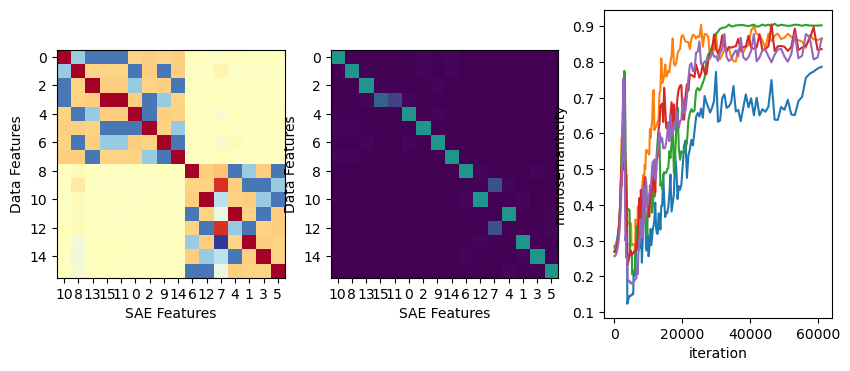

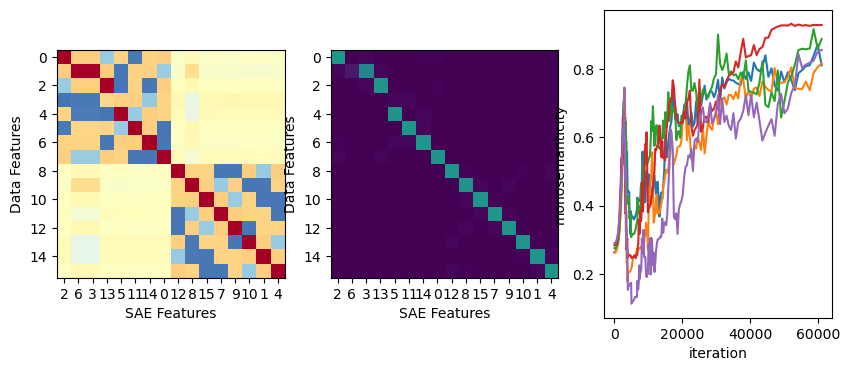

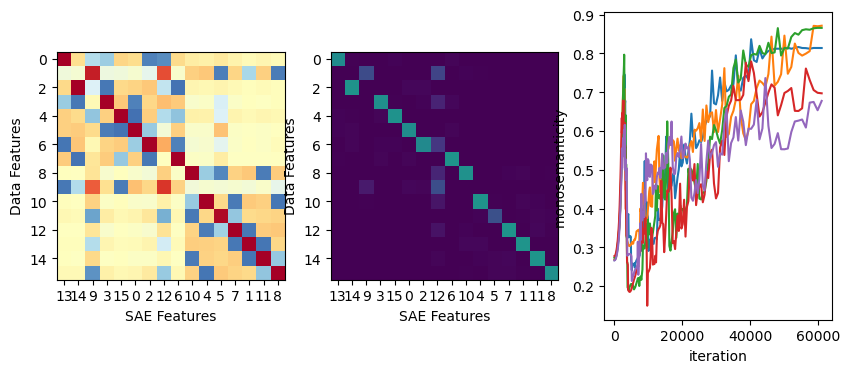

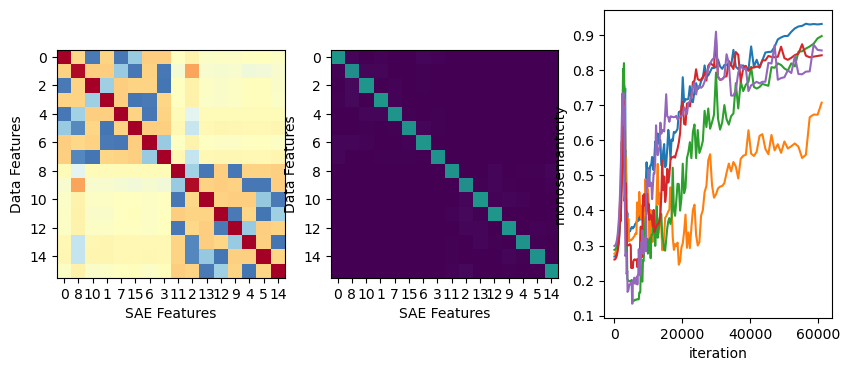

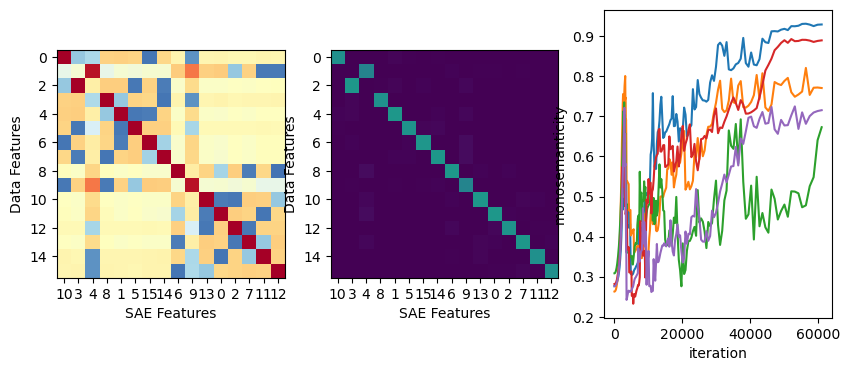

In [31]:
lr=3e-4
l1_coeff = 1
d_sae = feats_per_set*2

saes = []
sae_logs = []
for i, corr in enumerate(correlations):
    model = correlated_models[i] #TODO: I just added this; need to re-run!
    #can add a loop here and append
    proj_name = f"autoencoder-uncorrelated"
    en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                            n_inst=5,
                            training_samples = 64_000_000,
                            dict_mult=d_sae/cfg.hidden_size,
                            lr=lr,
                            adam_beta1=0,
                            wandb_project=proj_name,
                            l1_coeff=l1_coeff,
                            pre_encoder_bias=False
                            )
    print('running {}'.format(en_cfg.run_name))
    encoder = AutoEncoder(en_cfg).to(device)
    # help(encoder.train)
    outdir = rootdir/'8_in_6_saes_corr{:.2f}'.format(corr)
    outdir.mkdir(exist_ok=True)
    sae_log = encoder.train(model,rootdir=outdir, plot_cadence=1000)
    saes.append((encoder, model))
    sae_logs.append(sae_log)

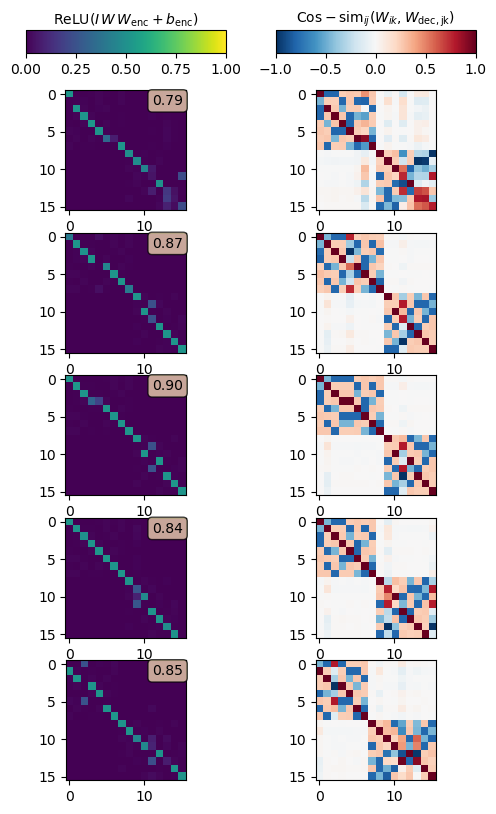

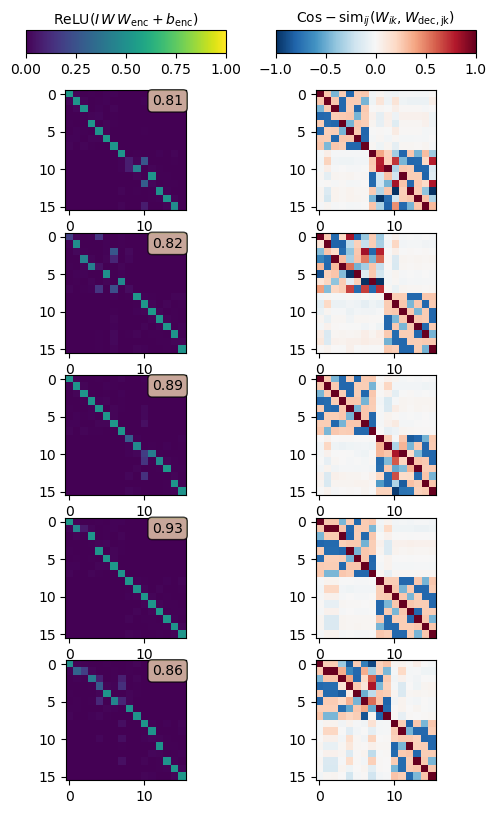

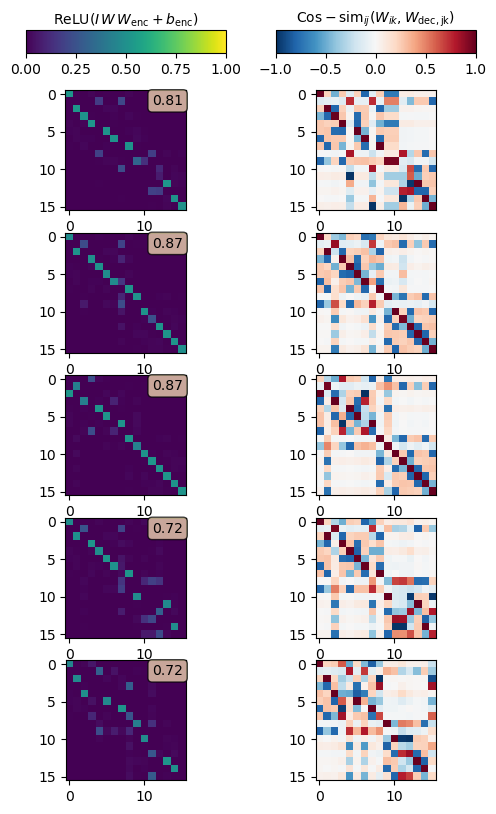

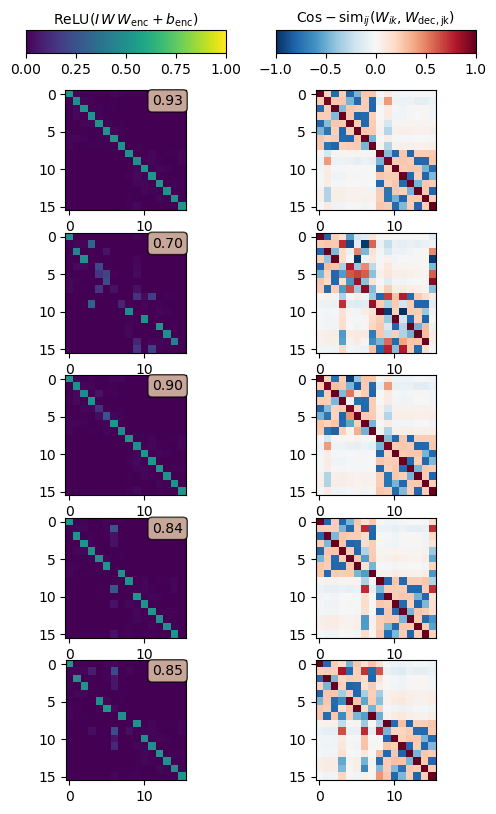

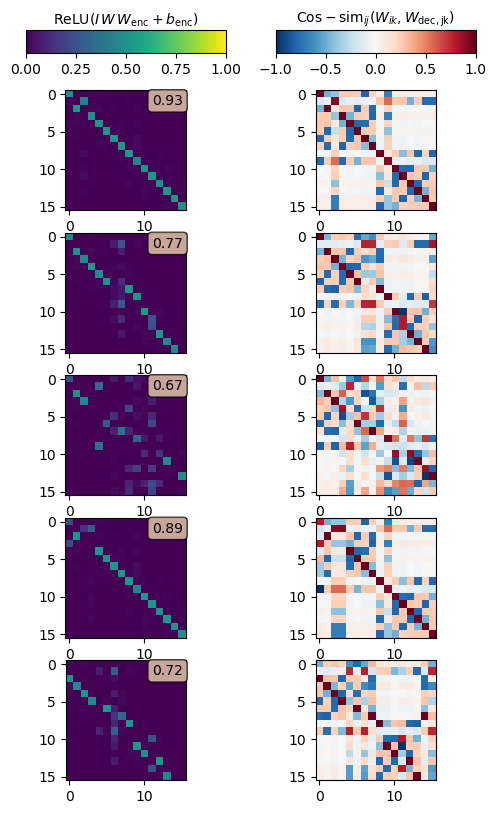

In [36]:
for i, corr in enumerate(correlations):
    plot_sae_imshows(saes[i][0], correlated_models[i], sae_logs[i])

### Model and first SAE

In [33]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
cfg = ToyModelConfig(hidden_size=2,
                     feat_sets=(2,2),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=(1,1),
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, 
                     onehot_probability=0.5,
                     )

model = ComposedFeatureTMS(cfg).to(device)
print(model.cfg.run_name)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)


probability table: 
tensor([[0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.0000]])
tms_nin4nhid2_numfeatsdraw1_magnitude_corr0_correlated_feature_boost0_onehot0.50
attempting to load


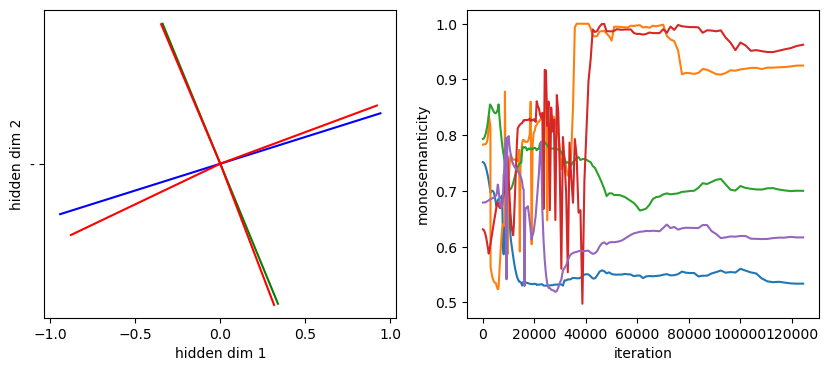

In [29]:
lr=3e-4
l1_coeff = 0.3


#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 128_000_000,
                        dict_mult=cfg.input_size/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
sae_log = encoder.train(model,rootdir=rootdir)
saes.append((encoder, model))
single_sae = encoder

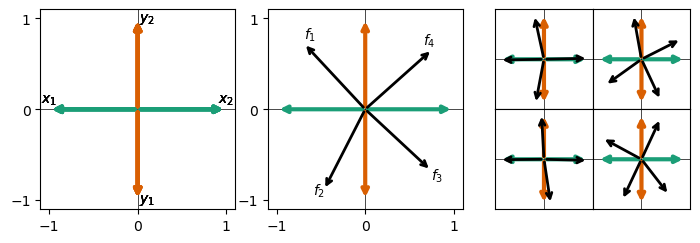

In [30]:
plot_schematic(model, single_sae, savename='2d_toy_model_schematic_oneHot50.png')

### SAE grid training

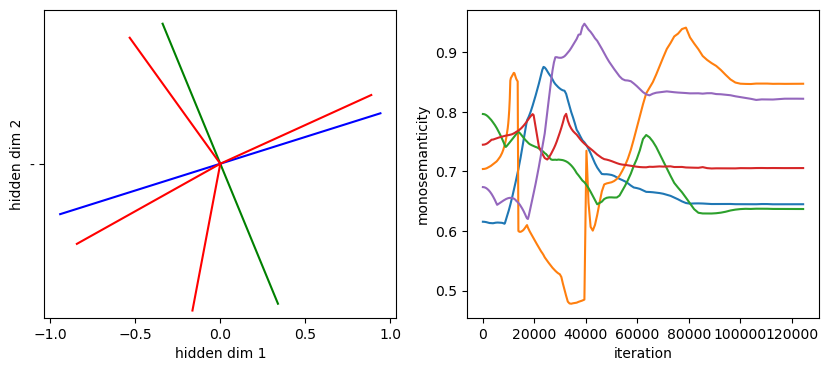

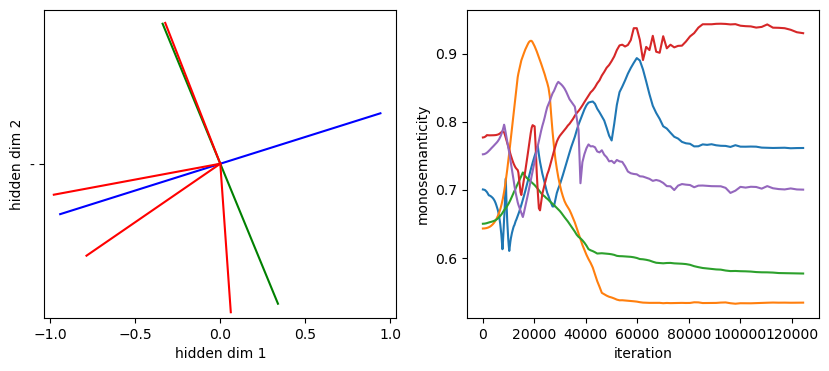

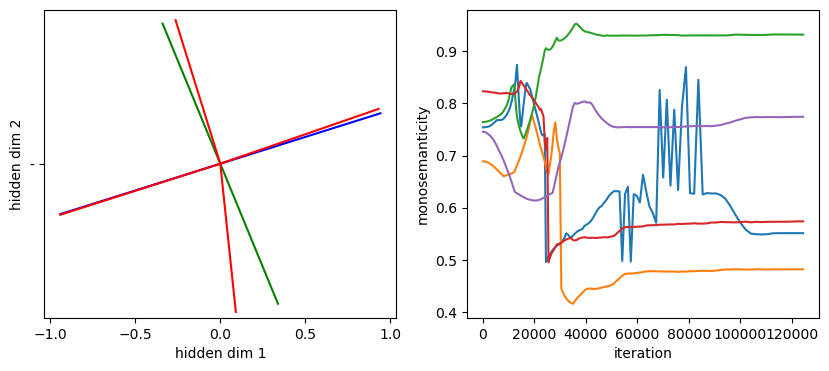

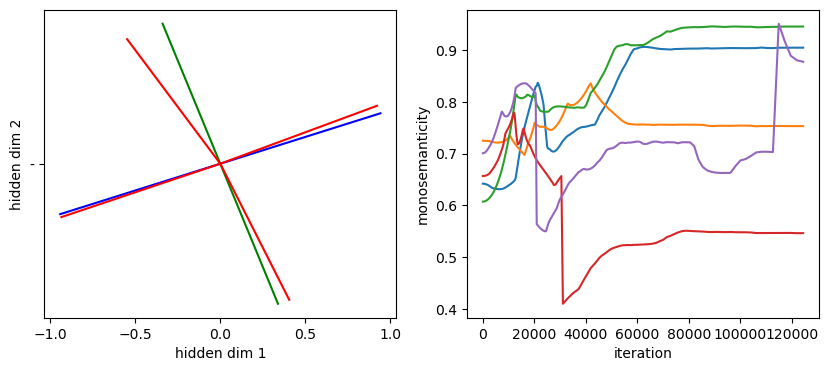

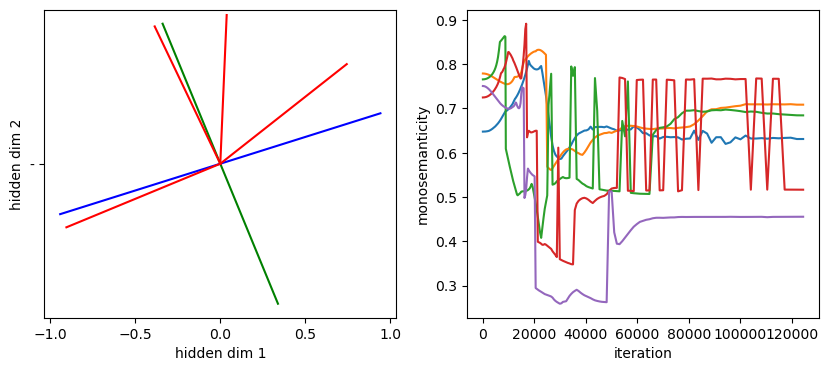

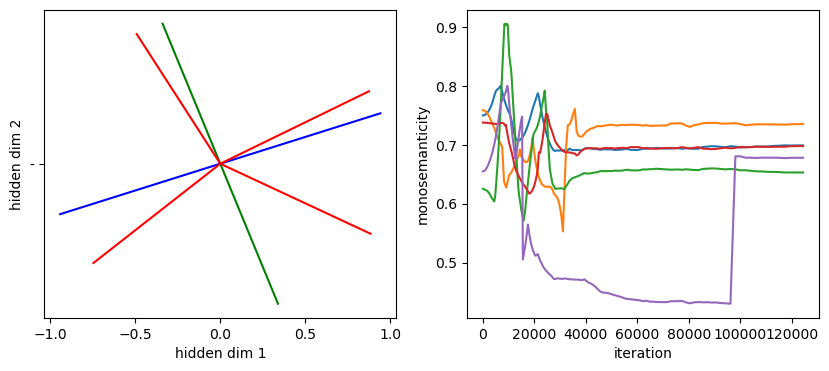

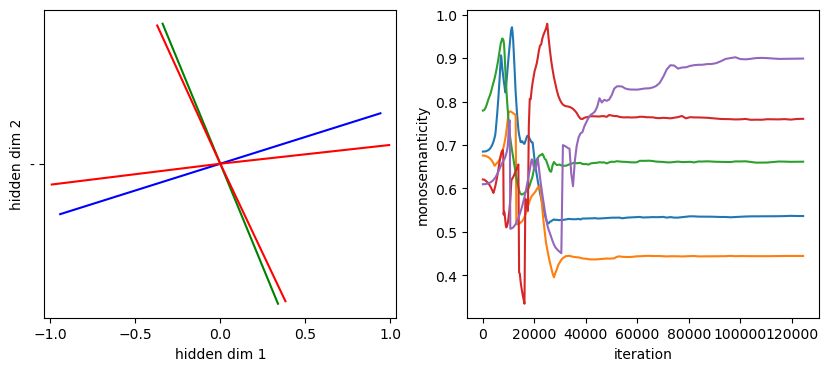

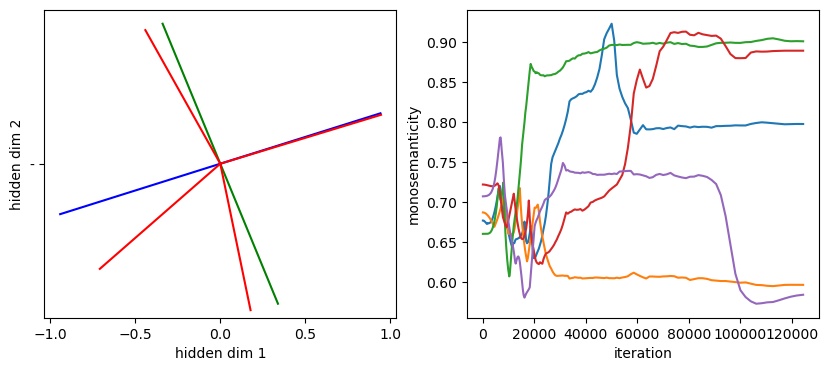

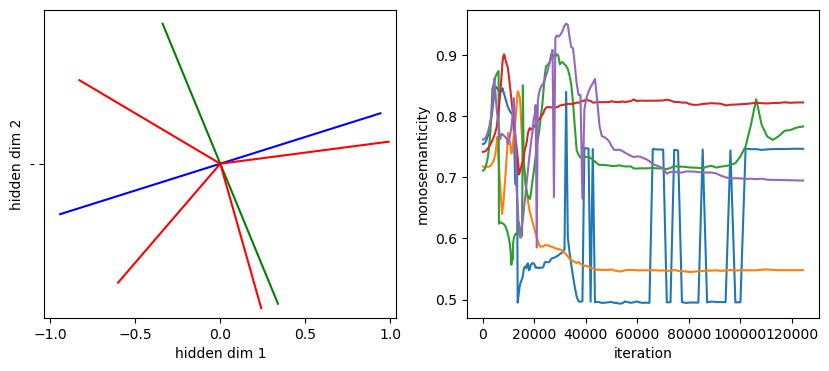

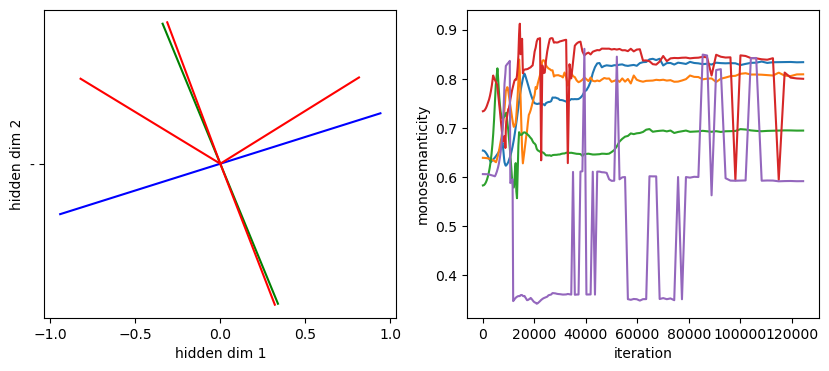

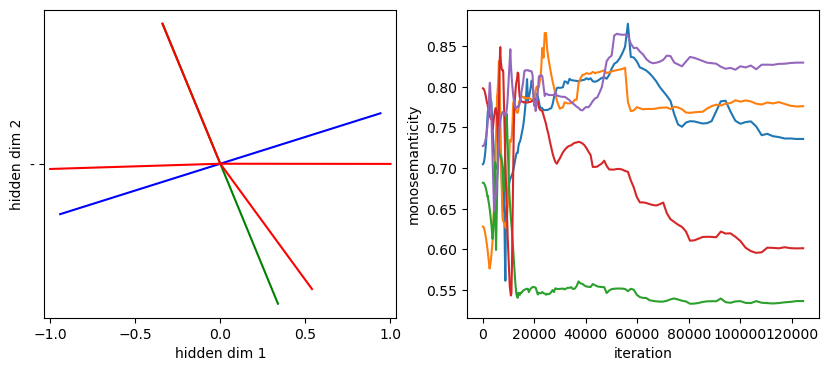

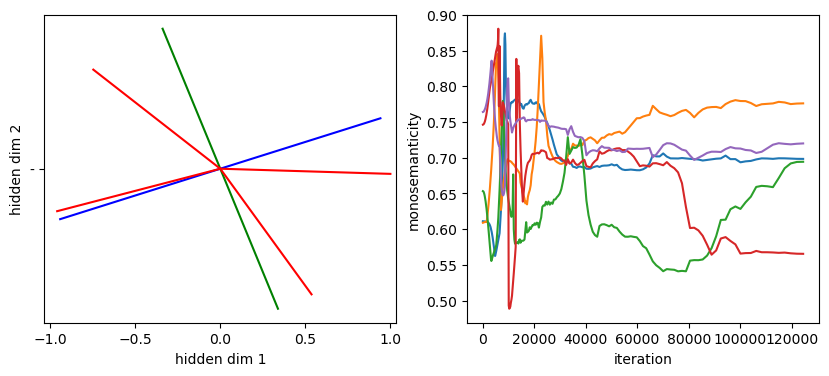

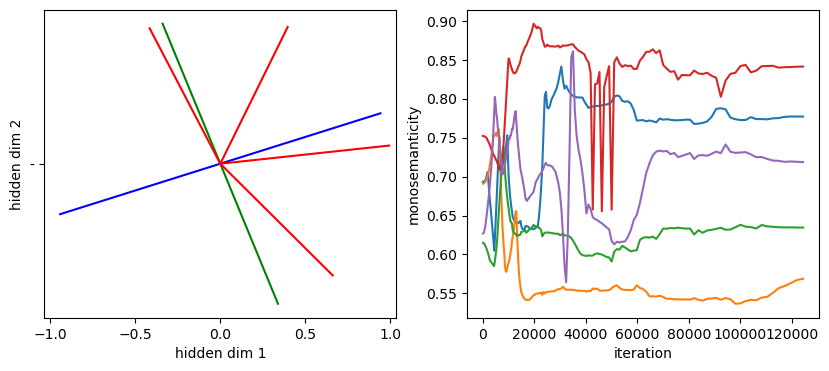

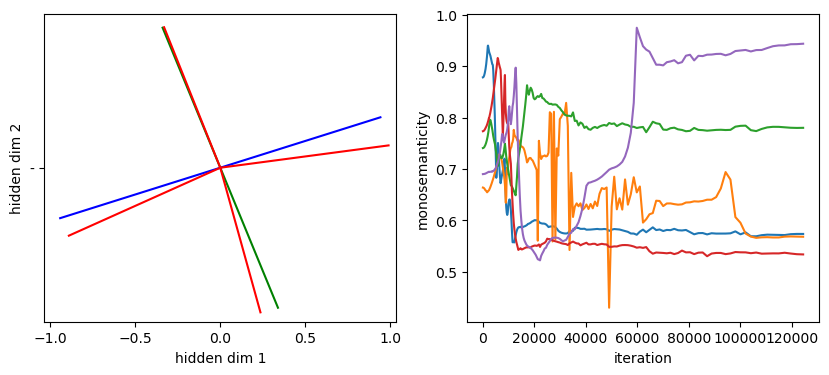

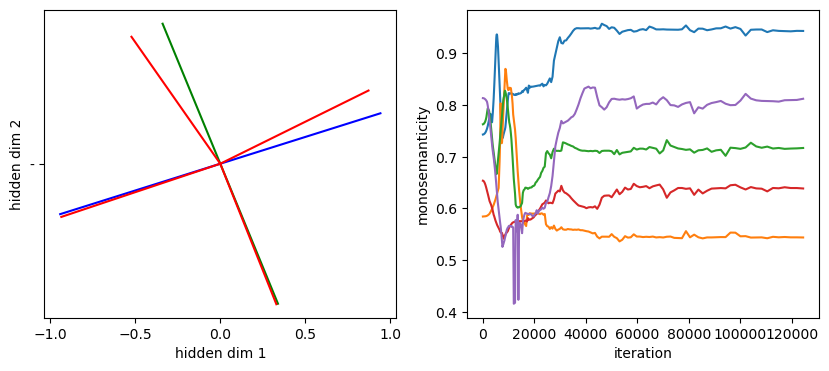

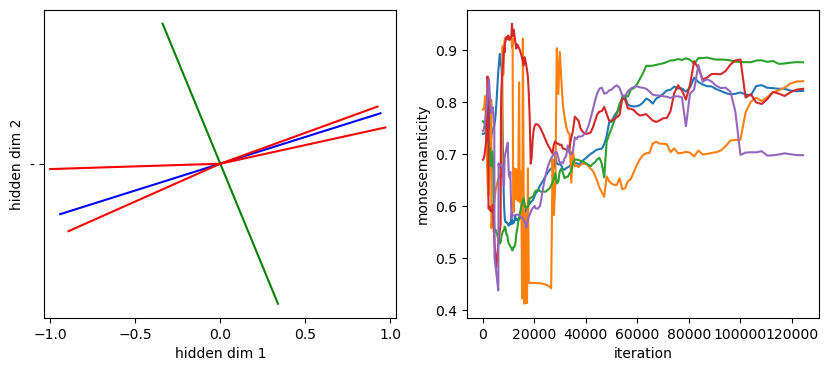

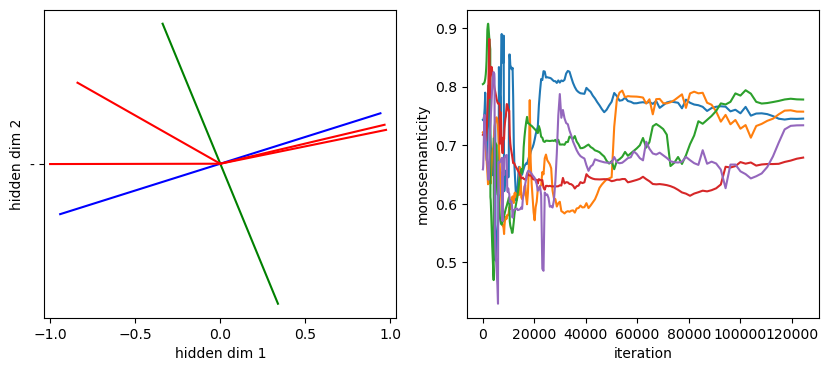

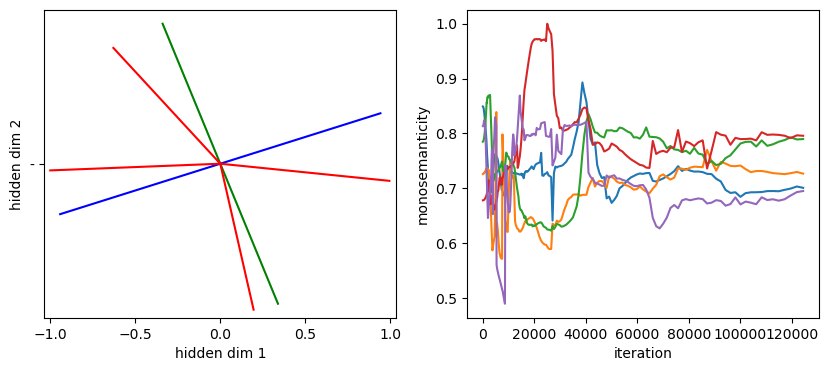

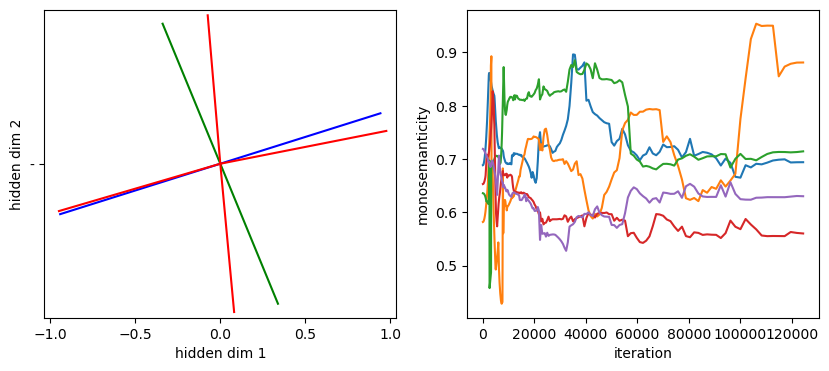

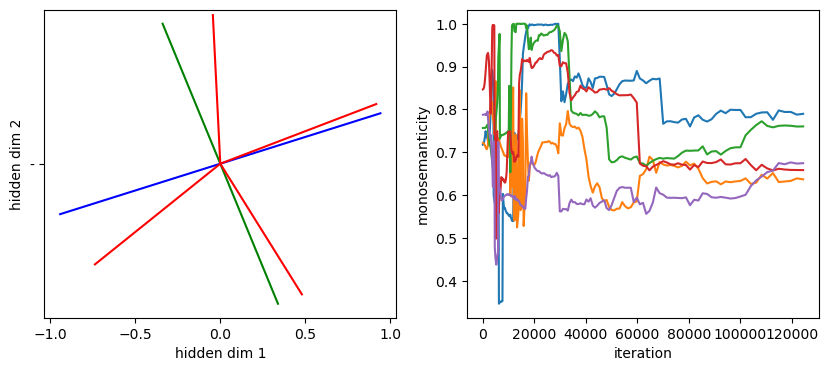

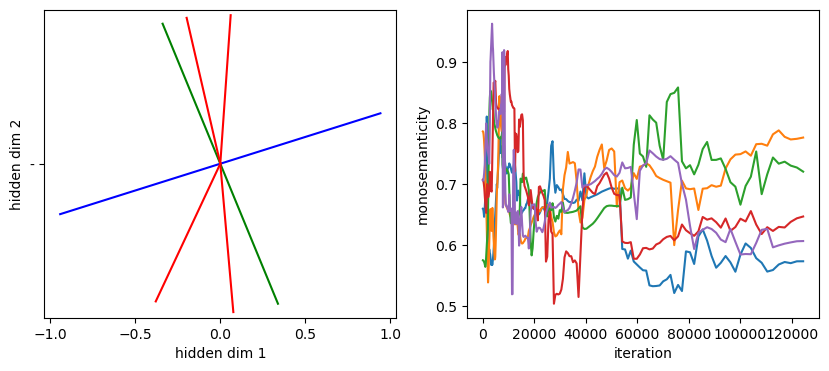

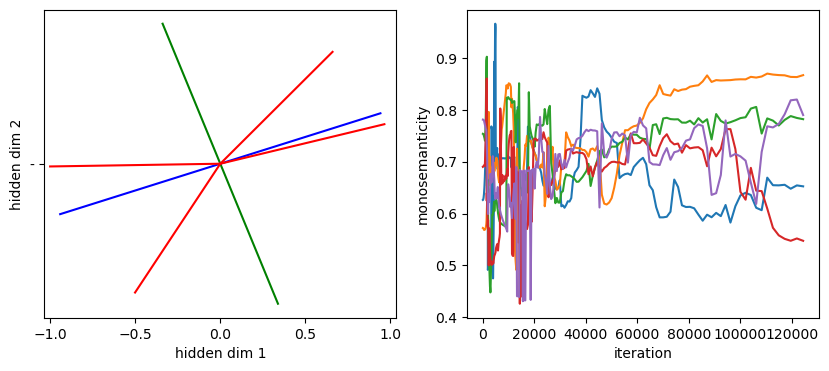

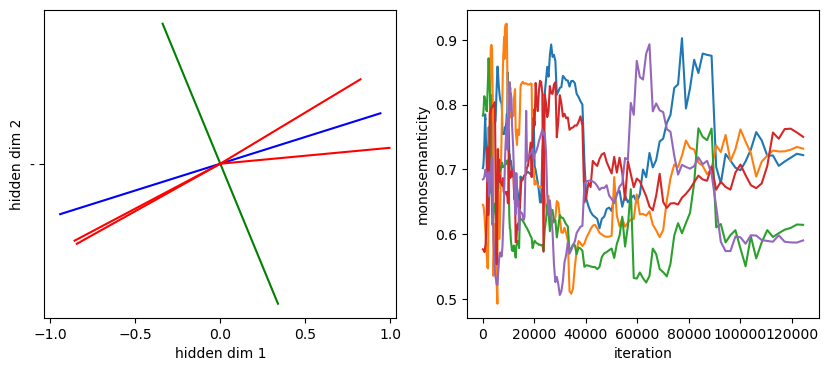

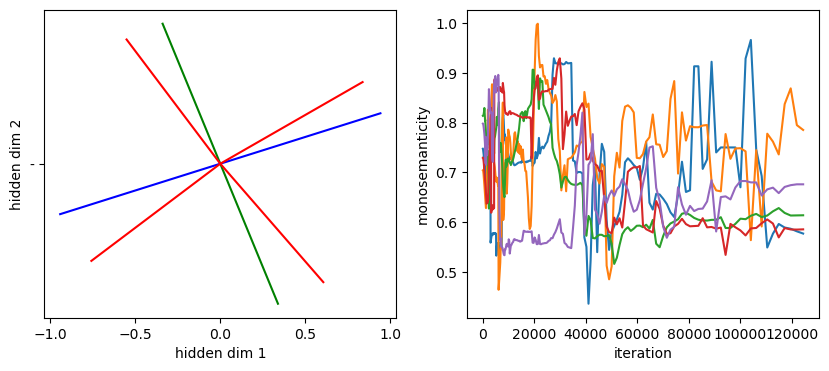

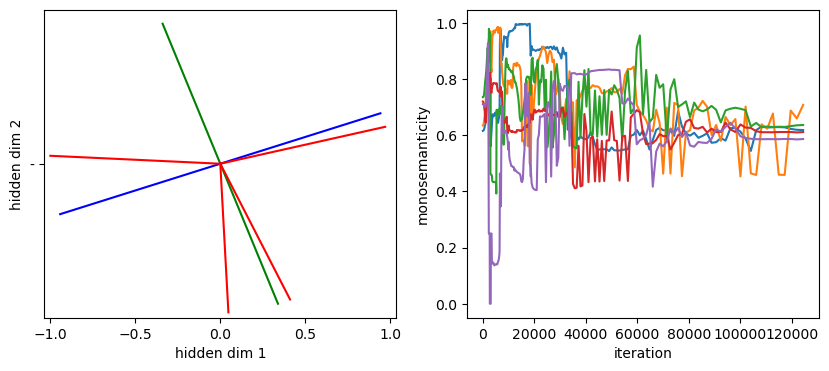

In [34]:
outdir = rootdir/'sae_OneHot50_uncorrelated'
outdir.mkdir(exist_ok=True)
d_sae = 4

saes = []
sae_logs = []
#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
for lr in [3e-5, 1e-4,3e-4, 1e-3, 3e-3]:
    for l1_coeff in [1e-2, 3e-2, 1e-1, 3e-1, 1e0]:
        en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                                n_inst=5,
                                training_samples = 128_000_000,
                                dict_mult=d_sae/cfg.hidden_size,
                                lr=lr,
                                adam_beta1=0,
                                wandb_project=proj_name,
                                l1_coeff=l1_coeff,
                                pre_encoder_bias=False
                                )
        print('running {}'.format(en_cfg.run_name))
        encoder = AutoEncoder(en_cfg).to(device)
        try:
            sae_log = encoder.load(outdir, run_name=en_cfg.run_name)
        except:
            sae_log = encoder.train(model,rootdir=outdir)
        saes.append((encoder, model))
        sae_logs.append(sae_log)
clear_output()

### SAE grid analysis

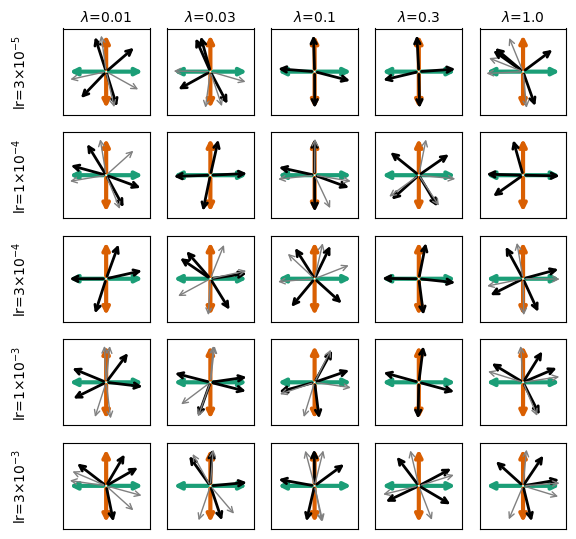

In [35]:
plot_grid(model, saes, filename='OneHot50_2d_grid.png')

/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_22890/3109989520.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(6.5,2))


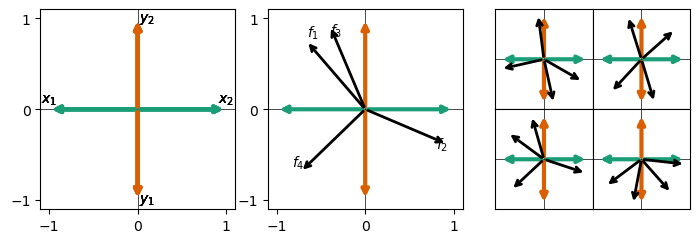

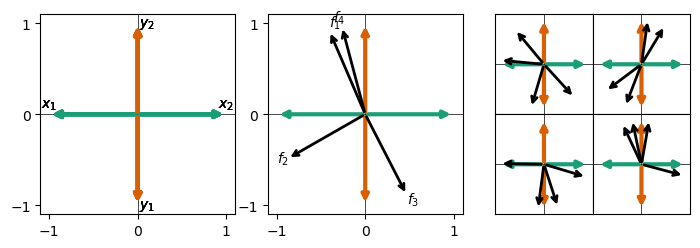

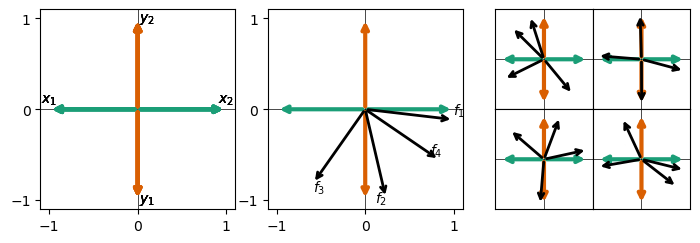

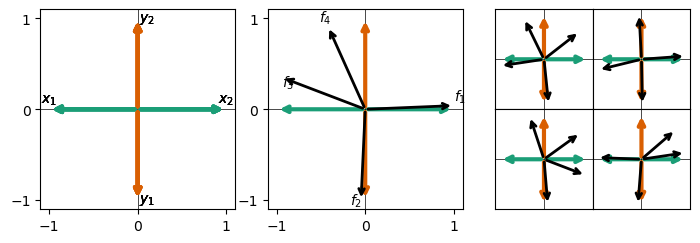

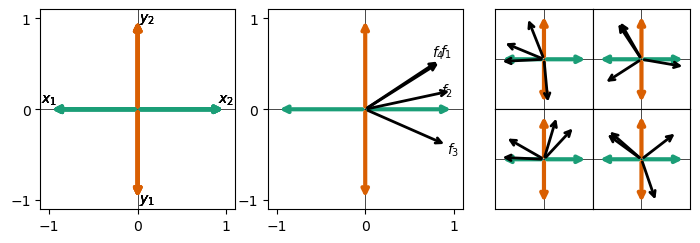

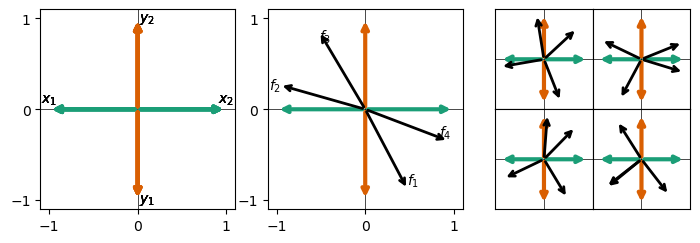

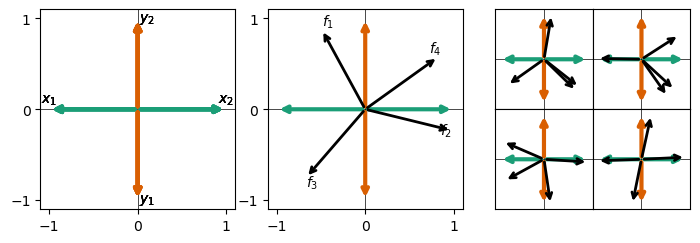

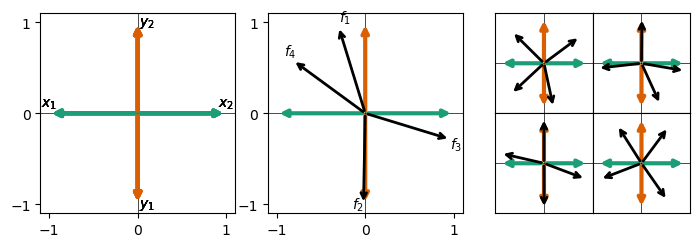

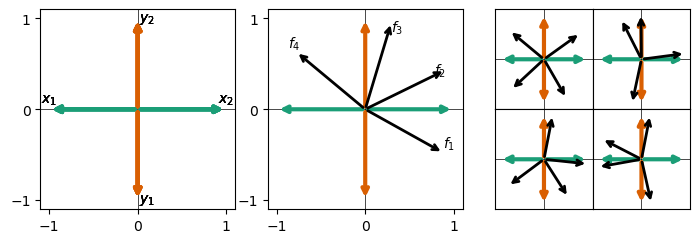

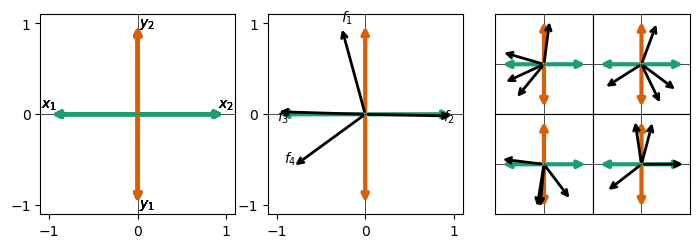

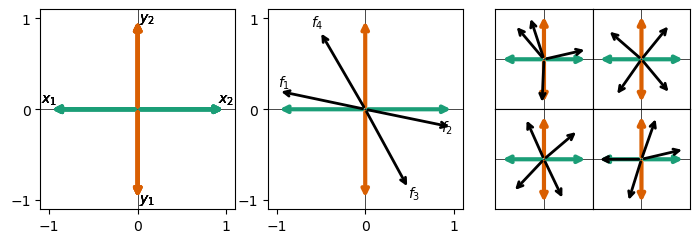

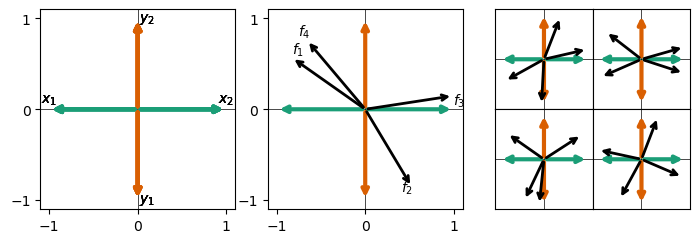

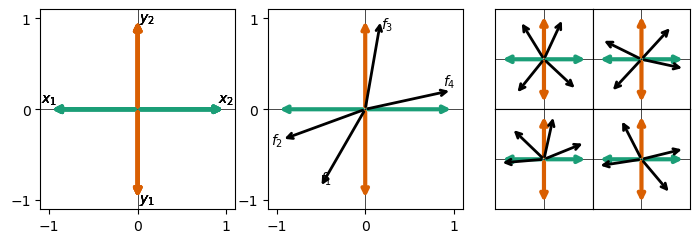

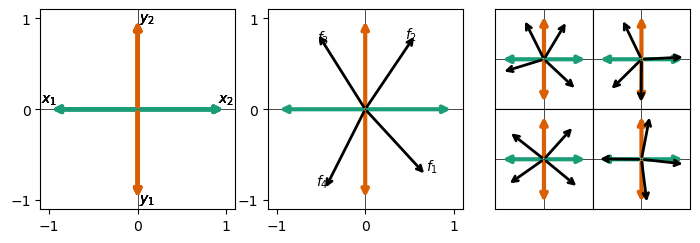

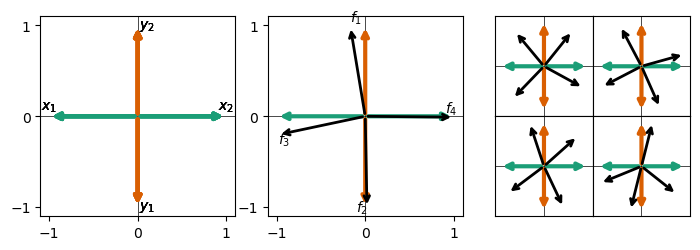

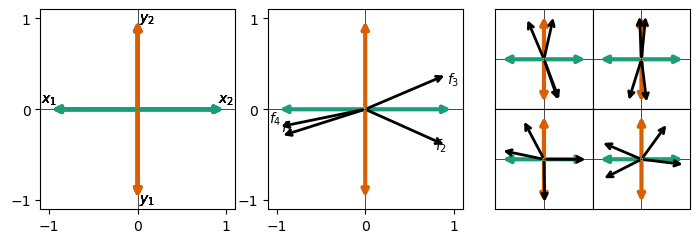

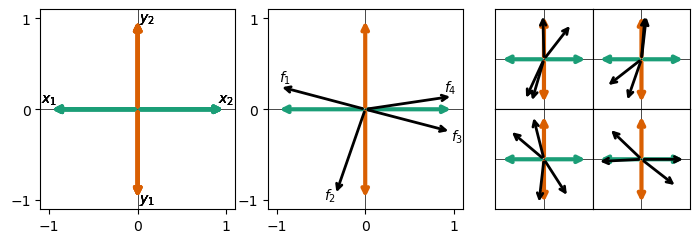

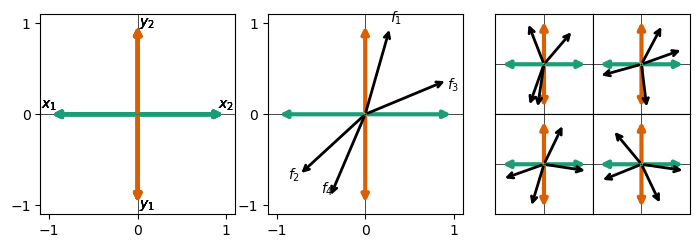

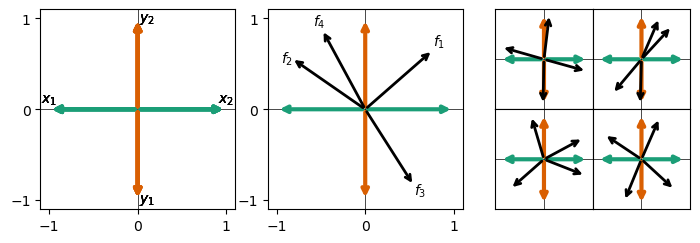

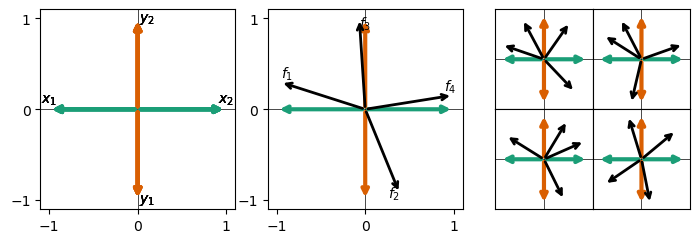

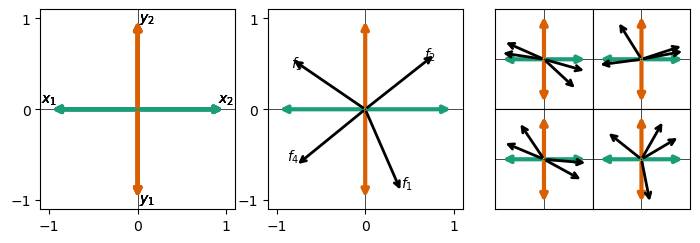

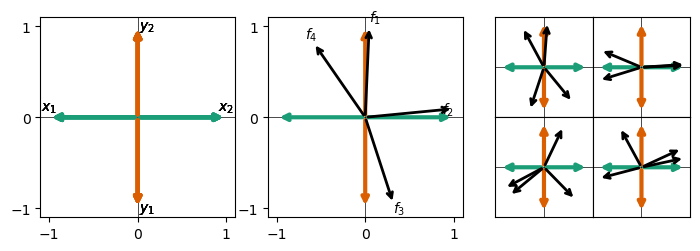

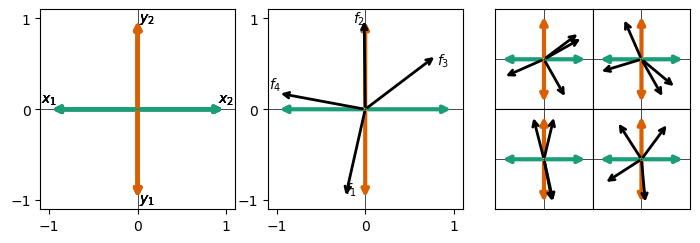

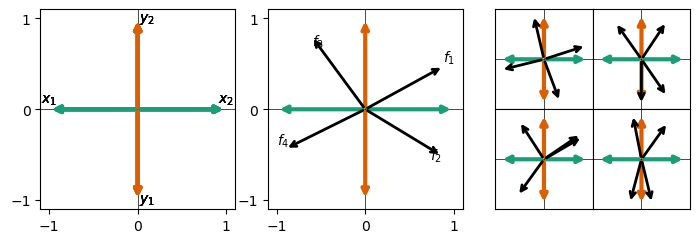

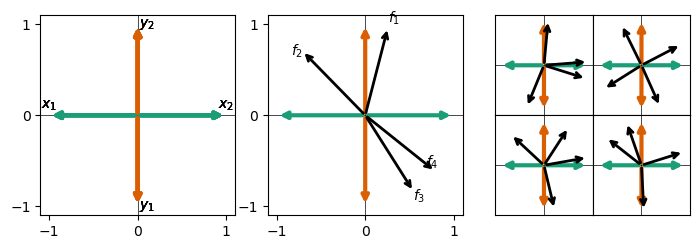

In [36]:
for i in range(len(saes)):
    plot_schematic(model, saes[i][0])

## Uncorrelated with one-hot probability at 75%

### Model and first SAE

In [32]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
cfg = ToyModelConfig(hidden_size=2,
                     feat_sets=(2,2),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=(1,1),
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, 
                     onehot_probability=0.75,
                     )

model = ComposedFeatureTMS(cfg).to(device)
print(model.cfg.run_name)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)


probability table: 
tensor([[0.0625, 0.0625, 0.1875],
        [0.0625, 0.0625, 0.1875],
        [0.1875, 0.1875, 0.0000]])
tms_nin4nhid2_numfeatsdraw1_magnitude_corr0_correlated_feature_boost0_onehot0.75
attempting to load


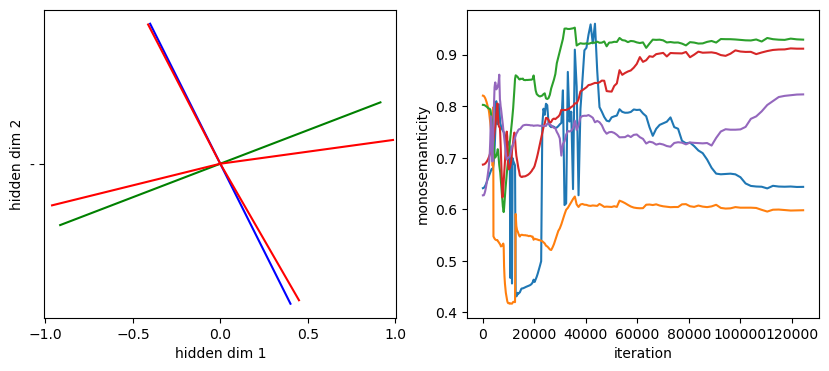

In [21]:
lr=3e-4
l1_coeff = 0.3


#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 128_000_000,
                        dict_mult=cfg.input_size/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
sae_log = encoder.train(model,rootdir=rootdir)
saes.append((encoder, model))
single_sae = encoder

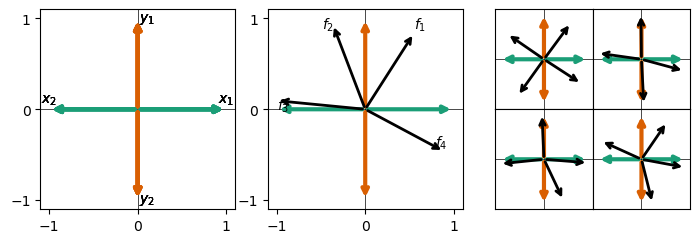

In [22]:
plot_schematic(model, single_sae, savename='2d_toy_model_schematic_oneHot75.png')

### SAE grid training

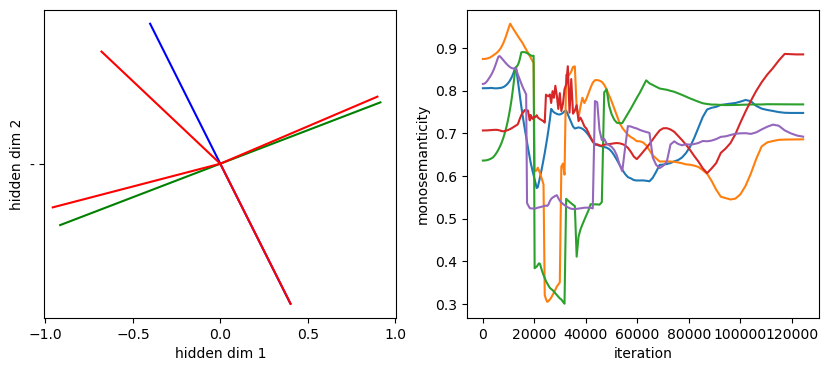

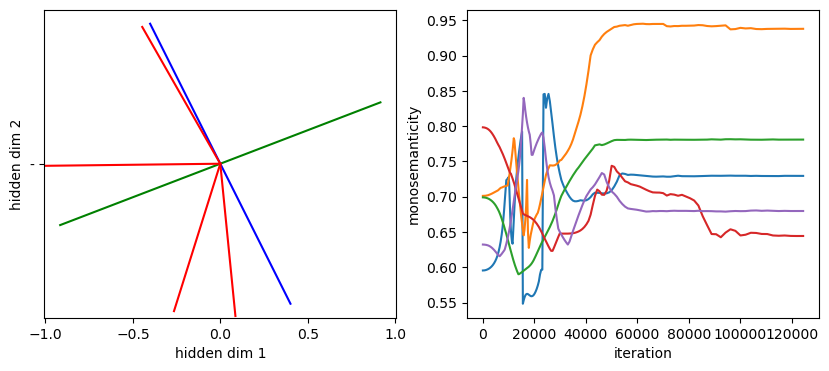

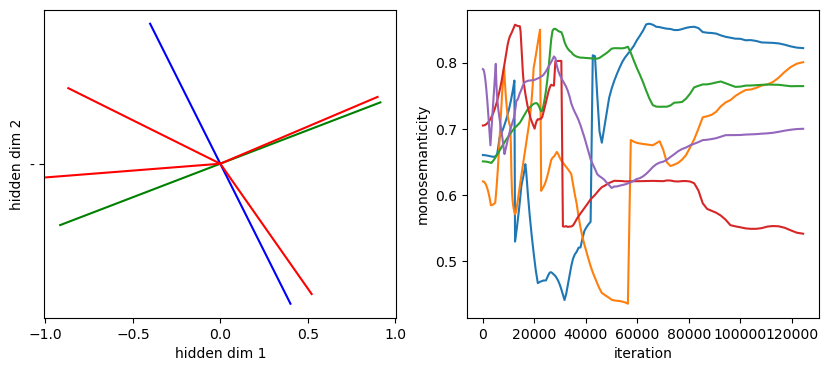

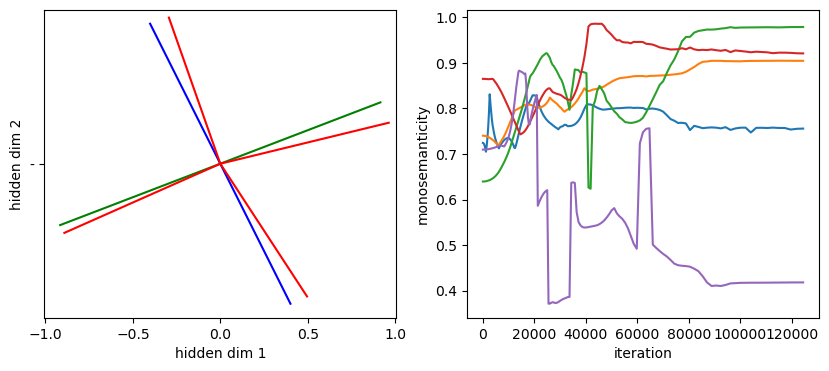

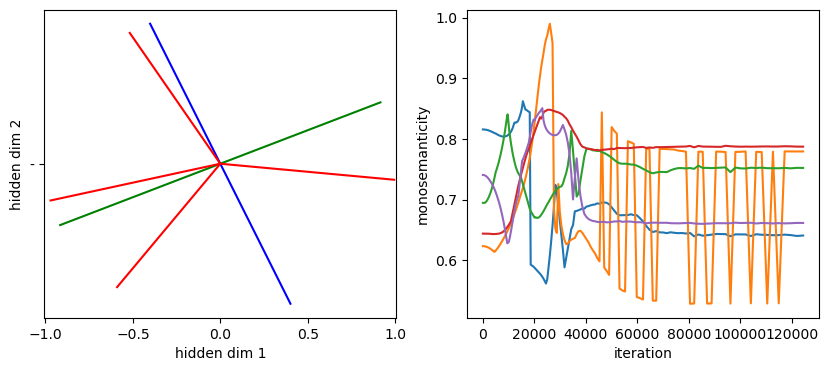

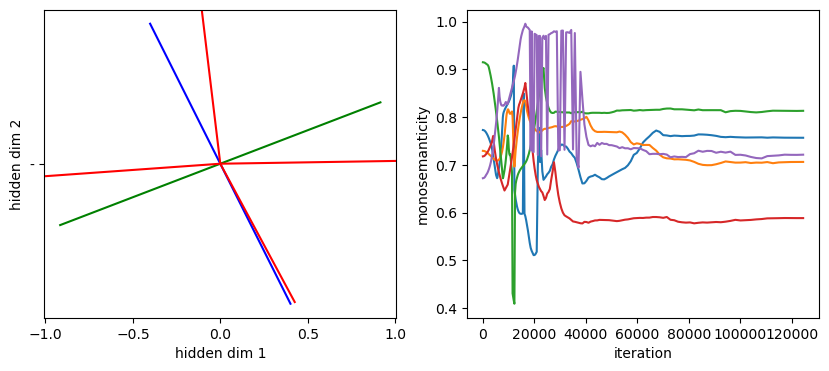

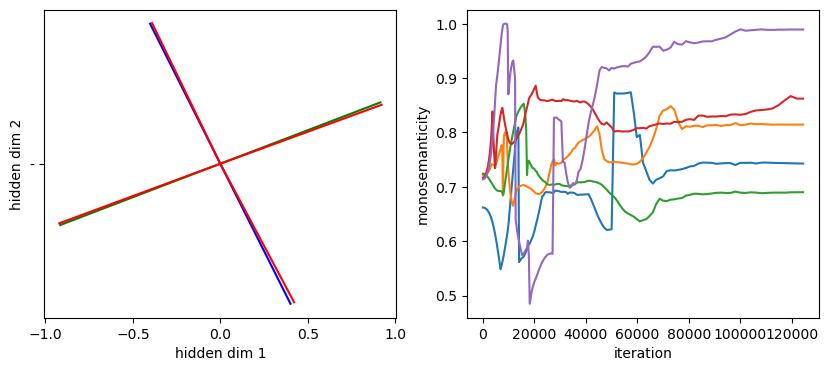

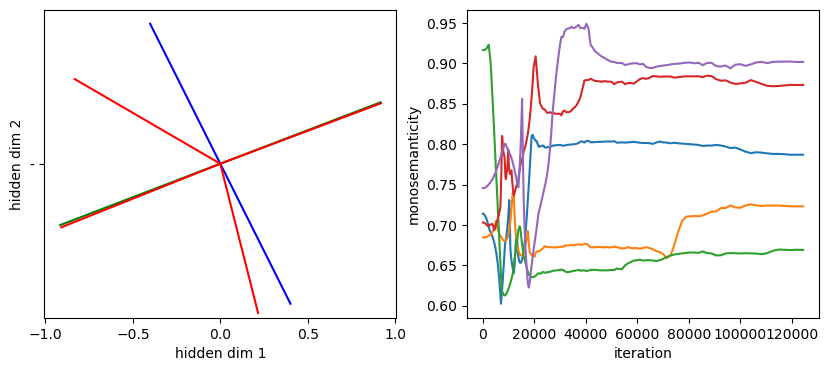

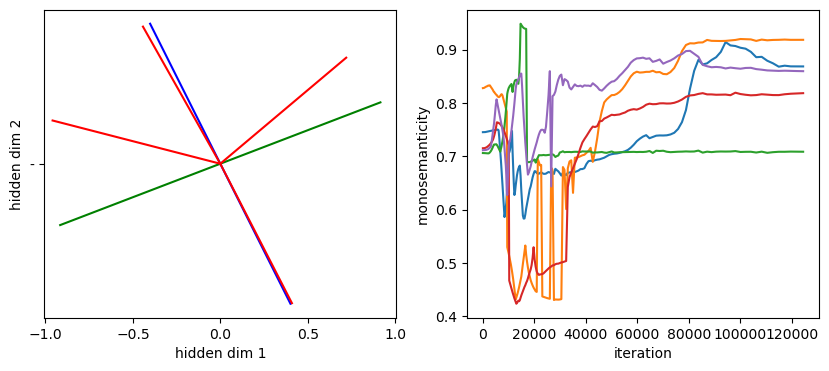

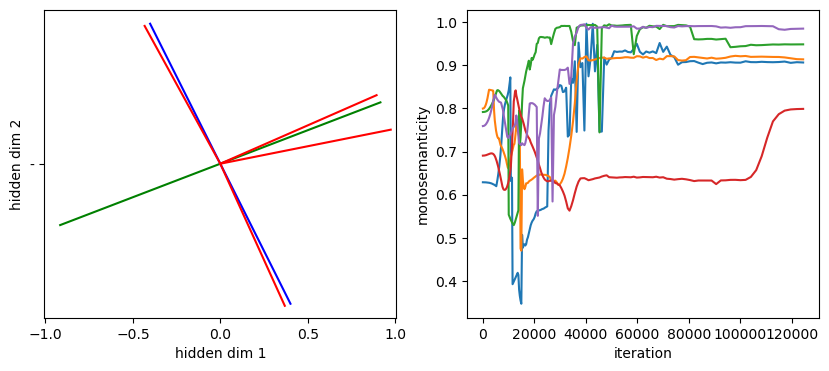

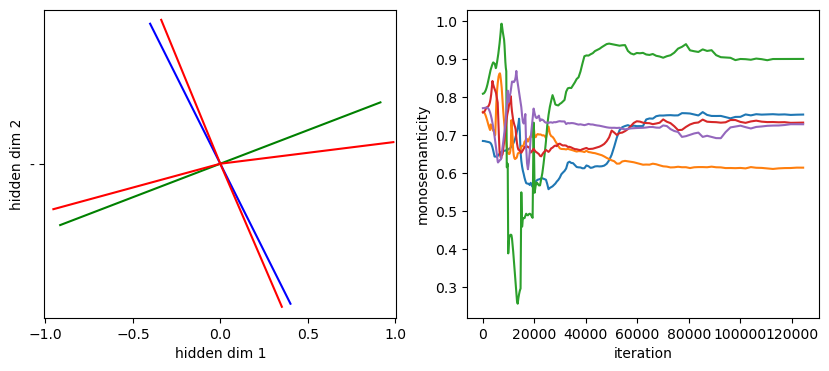

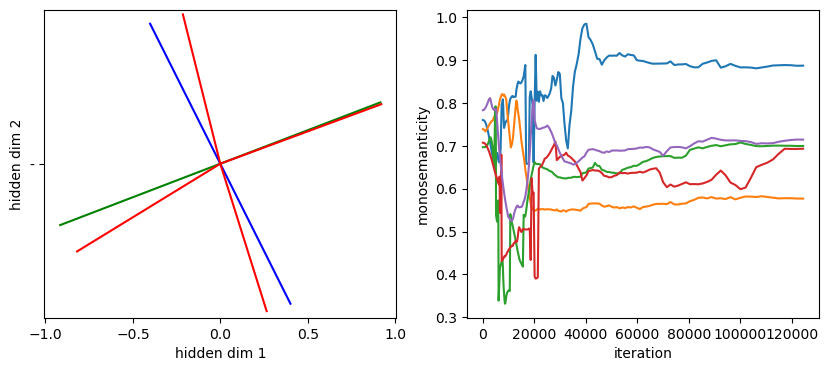

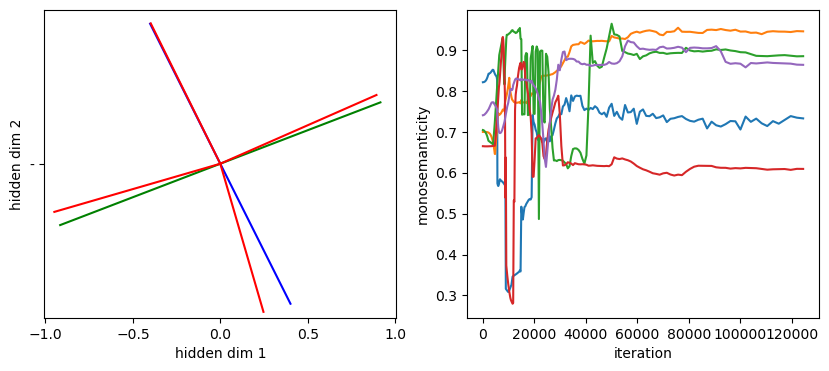

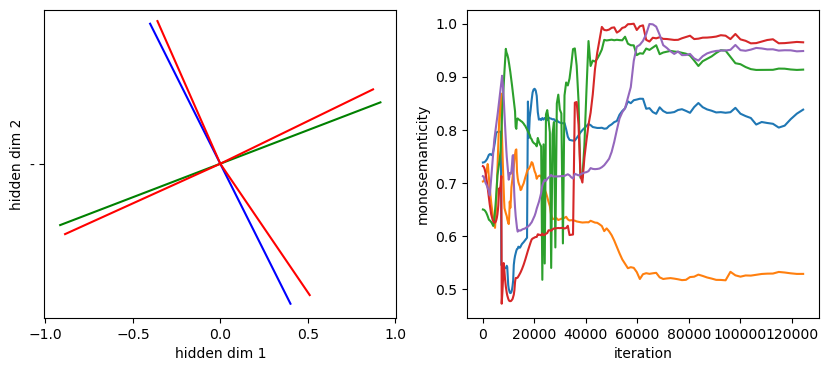

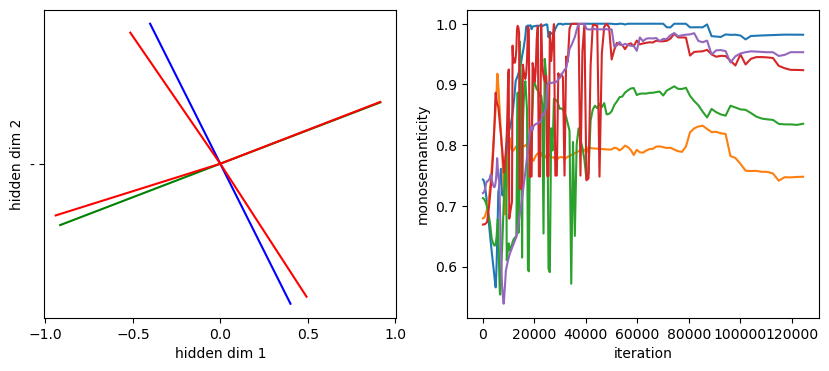

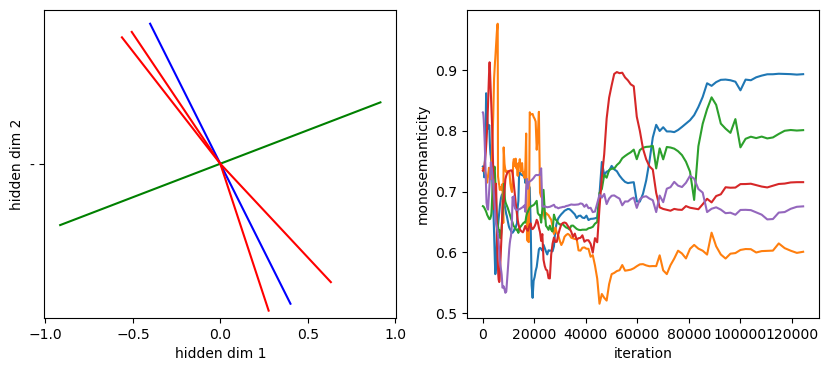

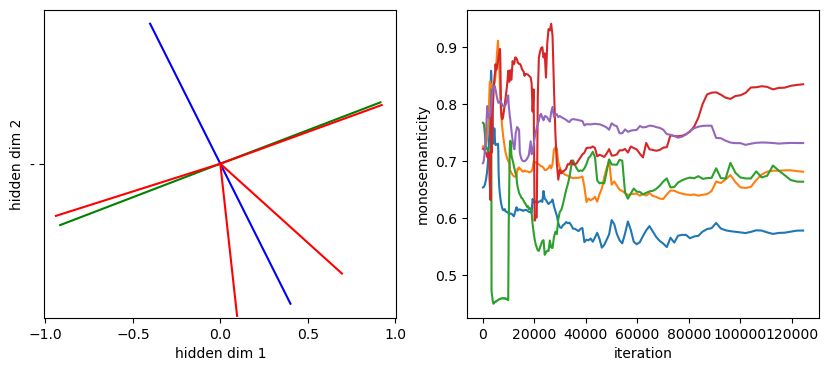

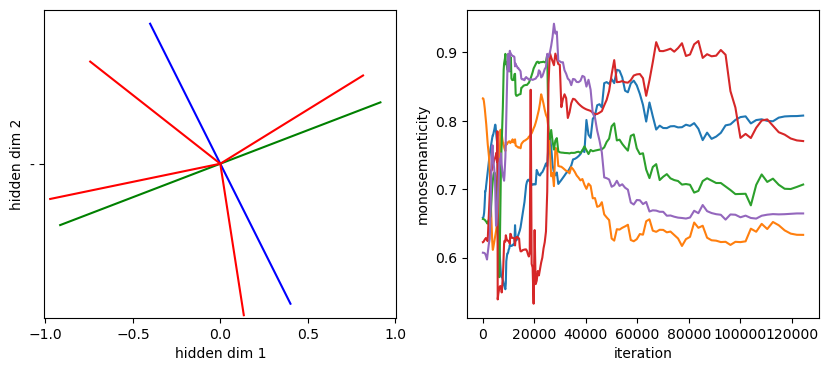

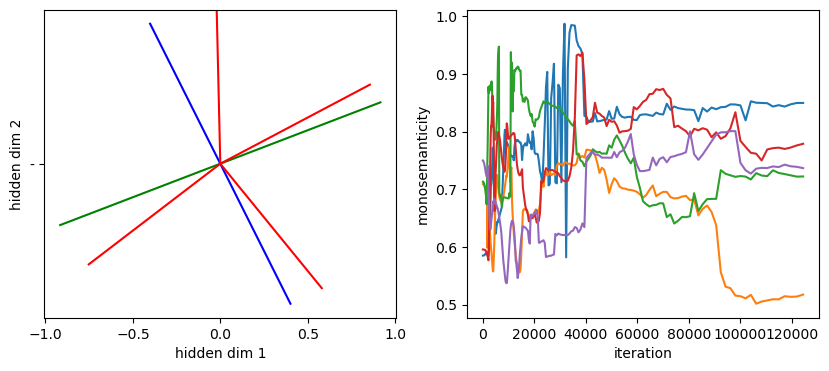

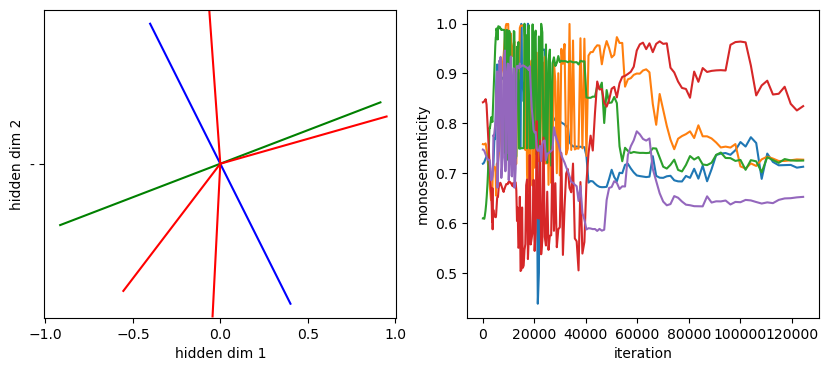

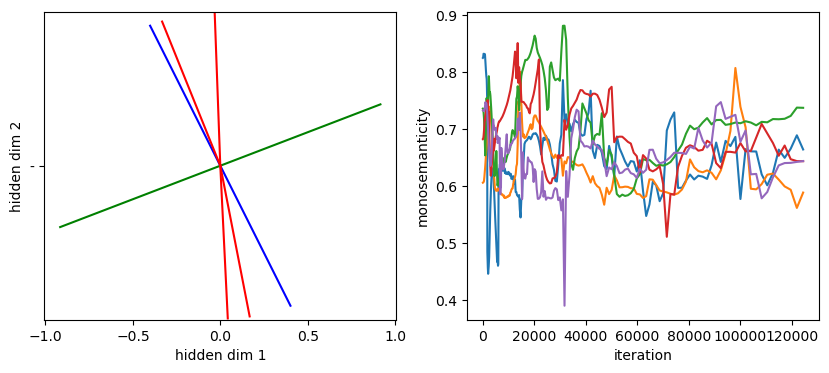

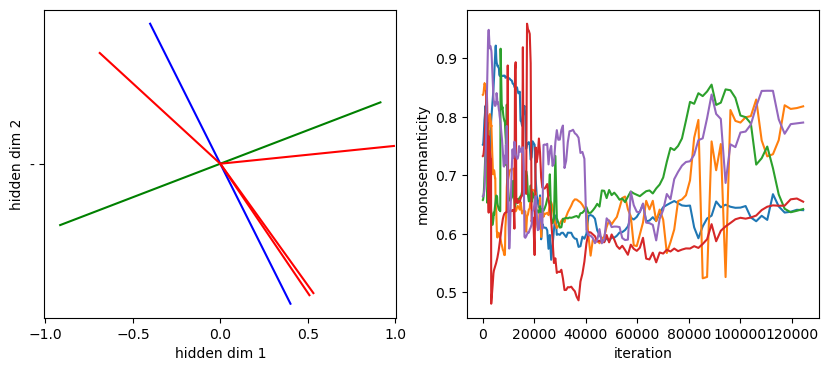

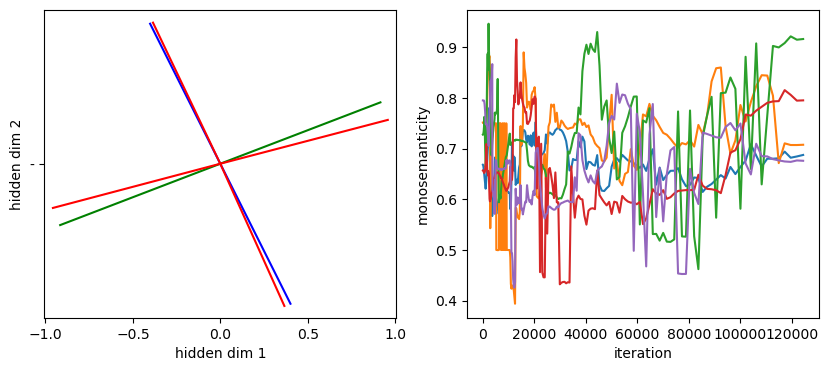

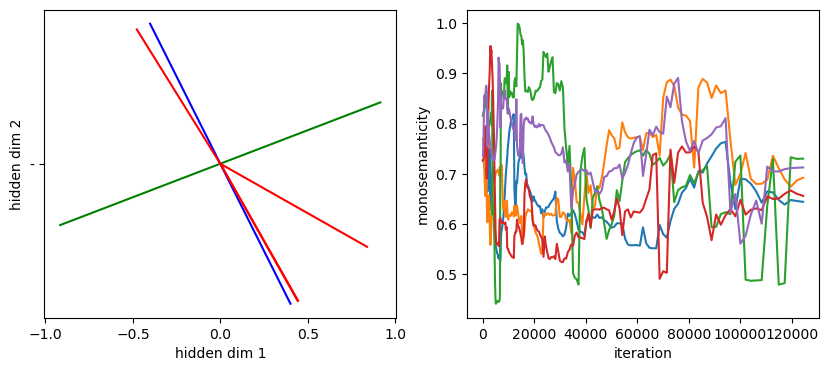

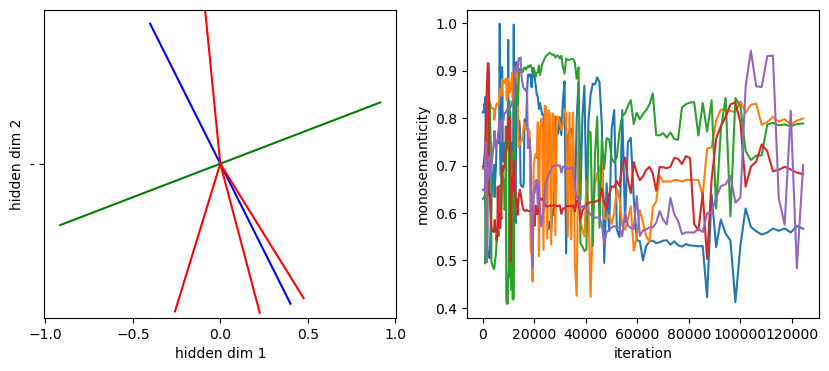

In [24]:
outdir = rootdir/'sae_OneHot75_uncorrelated'
outdir.mkdir(exist_ok=True)
d_sae = 4

saes = []
sae_logs = []
#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
for lr in [3e-5, 1e-4,3e-4, 1e-3, 3e-3]:
    for l1_coeff in [1e-2, 3e-2, 1e-1, 3e-1, 1e0]:
        en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                                n_inst=5,
                                training_samples = 128_000_000,
                                dict_mult=d_sae/cfg.hidden_size,
                                lr=lr,
                                adam_beta1=0,
                                wandb_project=proj_name,
                                l1_coeff=l1_coeff,
                                pre_encoder_bias=False
                                )
        print('running {}'.format(en_cfg.run_name))
        encoder = AutoEncoder(en_cfg).to(device)
        try:
            sae_log = encoder.load(outdir, run_name=en_cfg.run_name)
        except:
            sae_log = encoder.train(model,rootdir=outdir)
        saes.append((encoder, model))
        sae_logs.append(sae_log)
clear_output()

### SAE grid analysis

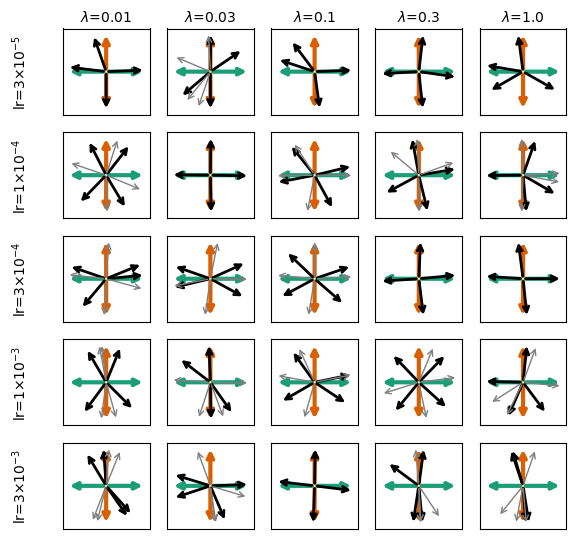

In [25]:
plot_grid(model, saes, filename='OneHot75_2d_grid.png')

/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_22890/3109989520.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(6.5,2))


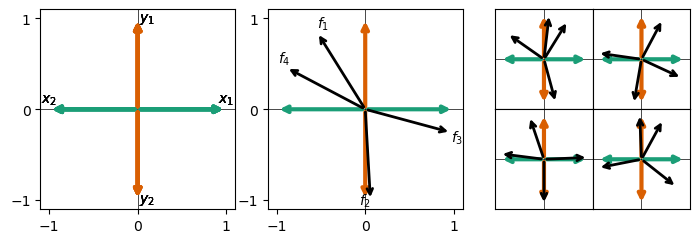

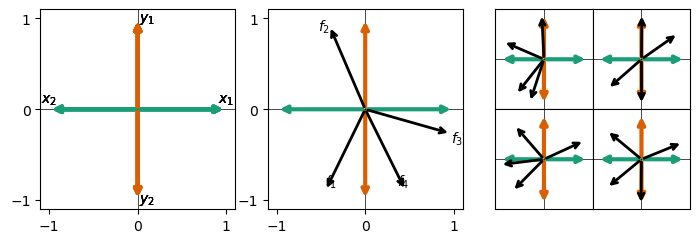

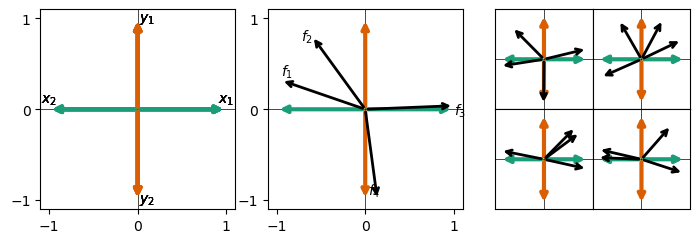

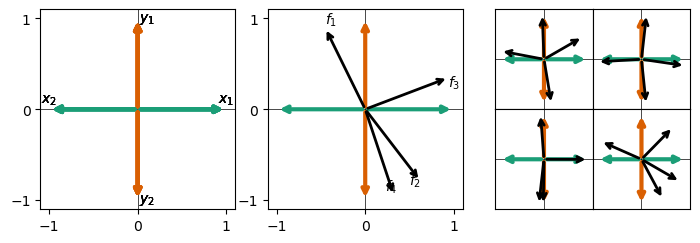

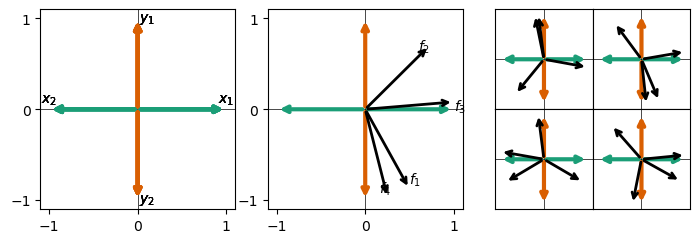

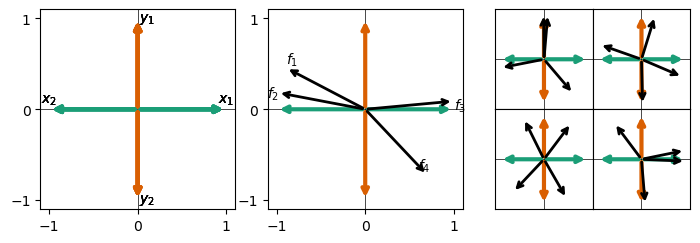

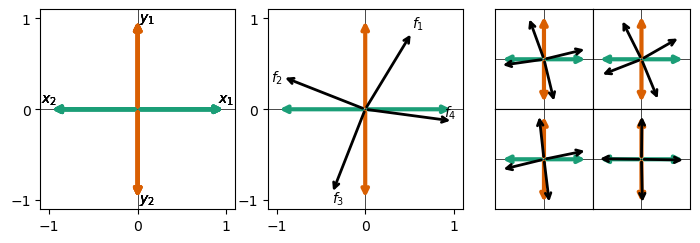

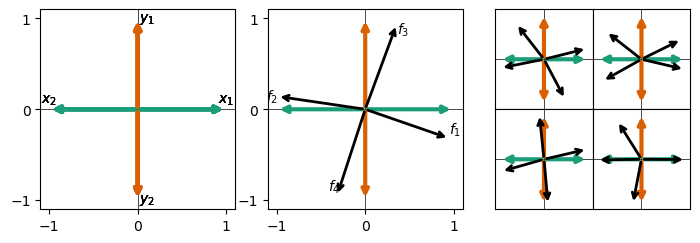

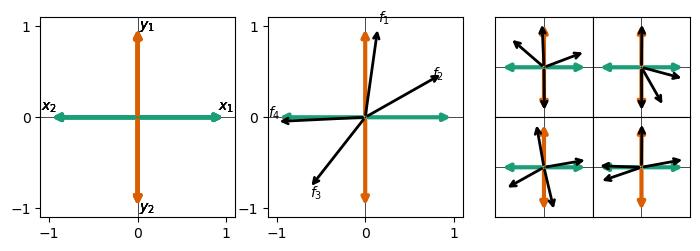

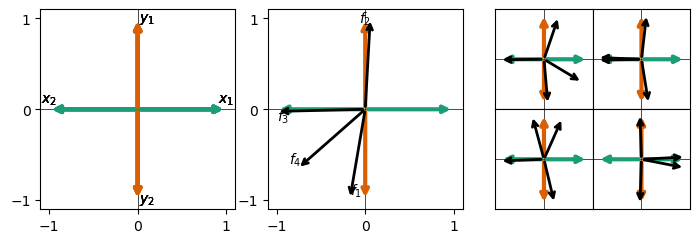

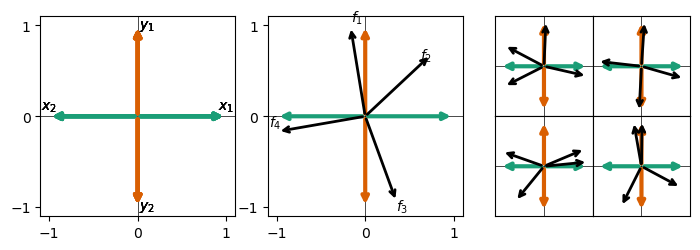

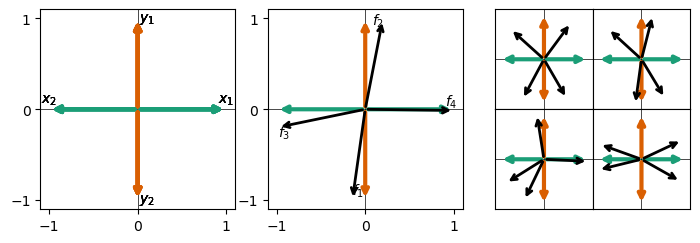

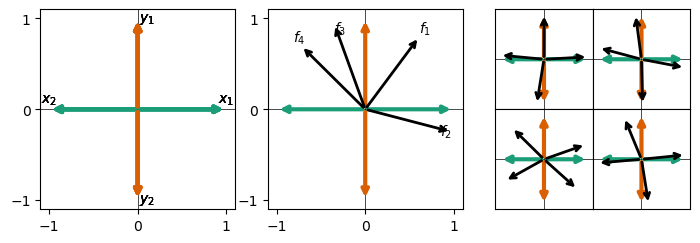

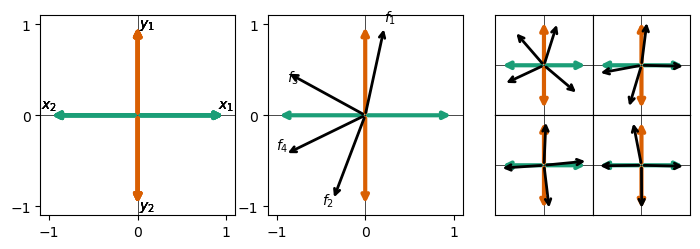

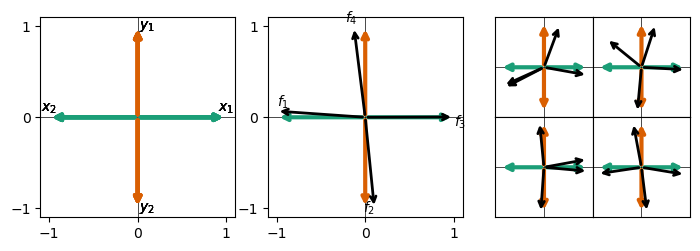

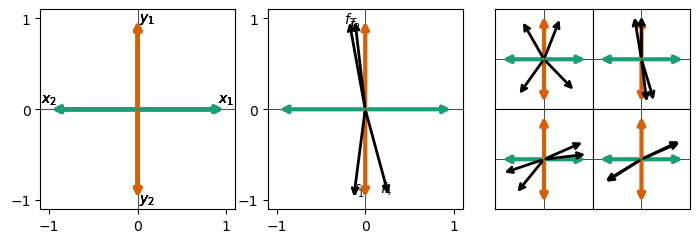

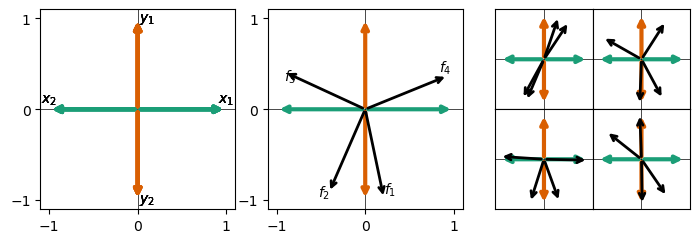

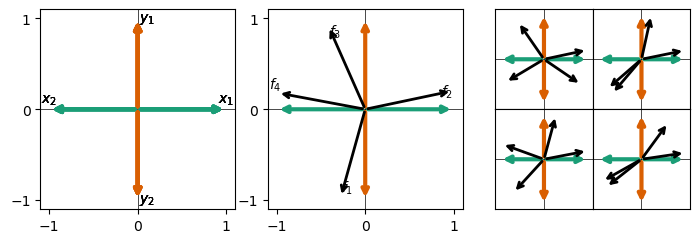

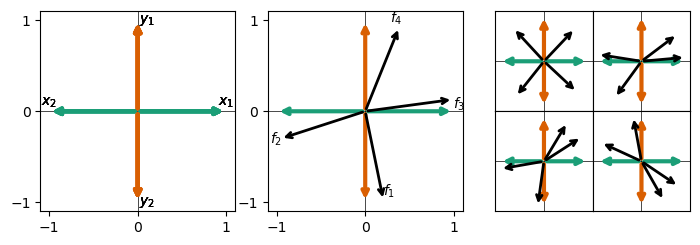

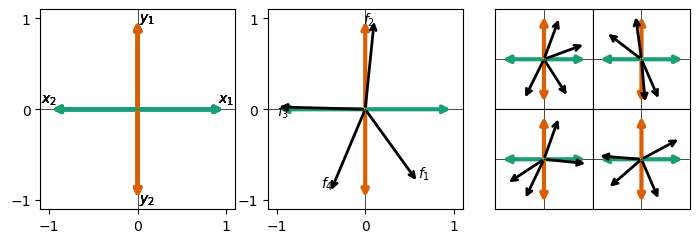

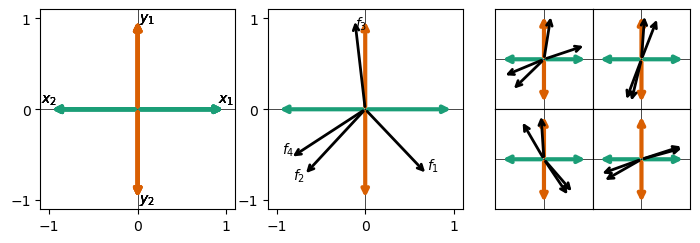

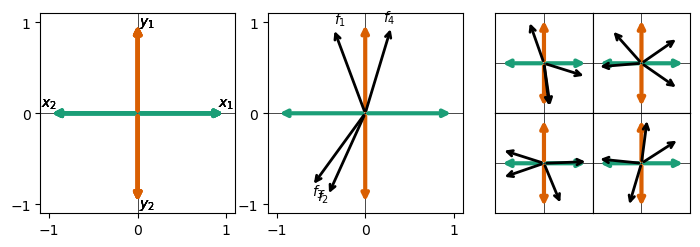

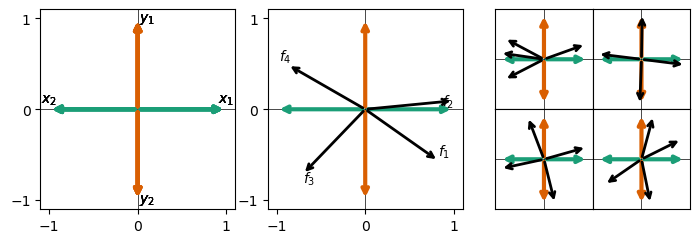

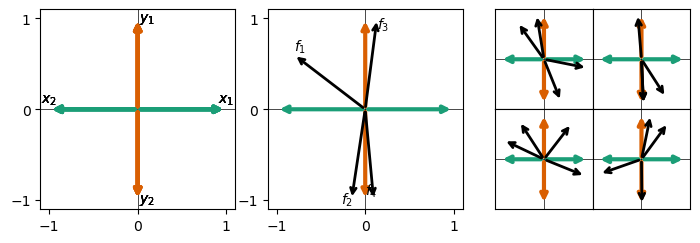

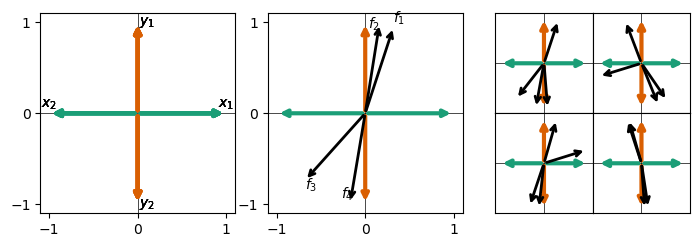

In [26]:
for i in range(len(saes)):
    plot_schematic(model, saes[i][0])